In [1]:
!nvidia-smi

Sun Oct 22 18:55:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   37C    P4              14W /  55W |      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary

In [3]:
torch.cuda.amp.autocast(enabled=False)

In [4]:
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer
from transformations import train_transforms,test_transforms

In [5]:
# ALbumentation
atrain_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
atest_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

acifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
atrain_loader, atest_loader = acifar.get_loader(atrain_dataset,atest_dataset)

In [6]:
# GET Train Loader

train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

cifar = CIFAR10DataLoader(batch_size=512,is_cuda_available=True)
train_loader, test_loader = cifar.get_loader(train_dataset,test_dataset)

# model 1

In [ ]:
class Network(nn.Module):
    def __init__(self,dp=0.1):
        super(Network,self).__init__()
        self.dp = dp
        self.c1 = ConvLayer(inc=3, outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c2 = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=1,dp_rate=self.dp) 
        self.c3 = ConvLayer(inc=16,outc=16,k=3,p=1,s=1,d=2,dp_rate=self.dp)
        self.t1 = TransBlock(inc=16,outc=8,p=0)

        self.c4 = ConvLayer(inc=8,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c5 = ConvLayer(inc=32,outc=32,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c6 = ConvLayer(inc=32,outc=32,k=3,p=0,s=1,d=4,dp_rate=self.dp)
        self.t2 = TransBlock(inc=32,outc=24,p=0)

        self.c7 = ConvLayer(inc=24,outc=40,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c8 = ConvLayer(inc=40,outc=40,k=3,p=1,s=1,d=1,dp_rate=self.dp)
        self.c9 = ConvLayer(inc=40,outc=40,k=3,p=0,s=1,d=8,dp_rate=self.dp)
        self.t3 = TransBlock(inc=40,outc=32,p=0)
        
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Sequential(TransBlock(inc=32,outc=10,p=0))
        
    def forward(self,x):
        x = self.c1(x)
        x = x + self.c2(x)
        x = self.c3(x)
        x = self.t1(x)
        
        x = self.c4(x)
        x = x + self.c5(x)
        x = self.c6(x)
        x = self.t2(x)
        
        x = self.c7(x)
        x = x + self.c8(x)
        x = self.c9(x)
        x = self.t3(x)
        
        x = self.gap(x)
        x = self.out(x)        
        return F.log_softmax(x.view(-1,10), dim=1)


# MODELS

# ModeL with Stride

$\delta$ `updates:`

- model used earlier above 44 rf
- instead of MP replace stride=2 in $3^{rd}$ layer of every Conv block
- epoch 20
- no aug
- few params

In [7]:
class Net(nn.Module):
        def __init__(self,channels:list,dp_rate=0.1):
            super(Net,self).__init__()
            self.dp_rate=dp_rate

            self.C1 = ConvLayer( inc=channels[0] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C2 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C3 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)
            self.t1 = TransBlock(inc=channels[1] ,outc=channels[1] ,p=0)

            self.C4 = ConvLayer(inc=channels[1], outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C5 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C6 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)
            self.t2 = TransBlock(inc=channels[2] ,outc=channels[2] ,p=0)

            self.C7 = ConvLayer(inc=channels[2] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C8 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C9 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)

            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            self.out = TransBlock(inc=channels[3] ,outc=channels[4] ,p=0)
            
        def forward(self,x):
            x = self.C1(x)
            x = self.C2(x)
            x = self.C3(x)
            x = self.t1(x)

            x = self.C4(x)
            x = self.C5(x)
            x = self.C6(x)
            x = self.t2(x)

            x = self.C7(x)
            x = self.C8(x)
            x = self.C9(x)
            x = self.gap(x)
            x = self.out(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [8]:
model1 = Net(dp_rate=0.15,channels=[3,8,16,32,10])
summary(model=model1,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─ConvLayer: 1-2                         [1, 8, 32, 32]            --
│    └─Sequential: 2-2                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            576
│    │    └─BatchNorm2d: 3-6             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-7                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-8               [1, 8, 32, 32]            --
├─ConvLayer: 

In [9]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model1.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model1, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model1, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model1.state_dict(),f='./bmodels/model1.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.98 | Batch = 97 | Accuracy = 20.00: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0038, Accuracy: 2892/10000 (28.92%)


EPOCH = 2 | LR = 0.1 | Loss = 1.80 | Batch = 97 | Accuracy = 28.66: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.78it/s]


Test set: Average loss: 0.0034, Accuracy: 3434/10000 (34.34%)


EPOCH = 3 | LR = 0.1 | Loss = 1.71 | Batch = 97 | Accuracy = 32.07: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.86it/s]


Test set: Average loss: 0.0034, Accuracy: 3530/10000 (35.30%)


EPOCH = 4 | LR = 0.1 | Loss = 1.72 | Batch = 97 | Accuracy = 33.84: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0032, Accuracy: 3933/10000 (39.33%)


EPOCH = 5 | LR = 0.1 | Loss = 1.66 | Batch = 97 | Accuracy = 35.07: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.83it/s]


Test set: Average loss: 0.0033, Accuracy: 3860/10000 (38.60%)


EPOCH = 6 | LR = 0.1 | Loss = 1.76 | Batch = 97 | Accuracy = 36.75: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.80it/s]


Test set: Average loss: 0.0031, Accuracy: 4224/10000 (42.24%)


EPOCH = 7 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 37.31: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.63it/s]


Test set: Average loss: 0.0030, Accuracy: 4286/10000 (42.86%)


EPOCH = 8 | LR = 0.1 | Loss = 1.61 | Batch = 97 | Accuracy = 38.18: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0030, Accuracy: 4477/10000 (44.77%)


EPOCH = 9 | LR = 0.1 | Loss = 1.58 | Batch = 97 | Accuracy = 39.47: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.77it/s]


Test set: Average loss: 0.0030, Accuracy: 4358/10000 (43.58%)


EPOCH = 10 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 40.34: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0029, Accuracy: 4552/10000 (45.52%)


EPOCH = 11 | LR = 0.1 | Loss = 1.52 | Batch = 97 | Accuracy = 41.31: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0029, Accuracy: 4666/10000 (46.66%)


EPOCH = 12 | LR = 0.1 | Loss = 1.59 | Batch = 97 | Accuracy = 41.65: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0029, Accuracy: 4710/10000 (47.10%)


EPOCH = 13 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 43.07: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.63it/s]


Test set: Average loss: 0.0028, Accuracy: 4856/10000 (48.56%)


EPOCH = 14 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 43.25: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.65it/s]


Test set: Average loss: 0.0027, Accuracy: 4870/10000 (48.70%)


EPOCH = 15 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 43.76: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.48it/s]


Test set: Average loss: 0.0027, Accuracy: 5044/10000 (50.44%)


EPOCH = 16 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 44.47: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.72it/s]


Test set: Average loss: 0.0028, Accuracy: 4822/10000 (48.22%)


EPOCH = 17 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 45.06: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.81it/s]


Test set: Average loss: 0.0026, Accuracy: 5125/10000 (51.25%)


EPOCH = 18 | LR = 0.1 | Loss = 1.39 | Batch = 97 | Accuracy = 45.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  3.92it/s]


Test set: Average loss: 0.0026, Accuracy: 5141/10000 (51.41%)


EPOCH = 19 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 46.16: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.89it/s]


Test set: Average loss: 0.0026, Accuracy: 5243/10000 (52.43%)


EPOCH = 20 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 46.77: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.90it/s]


Test set: Average loss: 0.0026, Accuracy: 5266/10000 (52.66%)


EPOCH = 21 | LR = 0.1 | Loss = 1.39 | Batch = 97 | Accuracy = 47.18: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.77it/s]


Test set: Average loss: 0.0025, Accuracy: 5344/10000 (53.44%)


EPOCH = 22 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 47.91: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0025, Accuracy: 5377/10000 (53.77%)


EPOCH = 23 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 48.33: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0025, Accuracy: 5488/10000 (54.88%)


EPOCH = 24 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 48.64: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0025, Accuracy: 5494/10000 (54.94%)


EPOCH = 25 | LR = 0.1 | Loss = 1.43 | Batch = 97 | Accuracy = 49.10: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.89it/s]


Test set: Average loss: 0.0025, Accuracy: 5525/10000 (55.25%)


EPOCH = 26 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 49.15: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.89it/s]


Test set: Average loss: 0.0024, Accuracy: 5637/10000 (56.37%)


EPOCH = 27 | LR = 0.1 | Loss = 1.33 | Batch = 97 | Accuracy = 49.47: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.86it/s]


Test set: Average loss: 0.0025, Accuracy: 5547/10000 (55.47%)


EPOCH = 28 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 50.01: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.65it/s]


Test set: Average loss: 0.0024, Accuracy: 5700/10000 (57.00%)


EPOCH = 29 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 50.27: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0024, Accuracy: 5646/10000 (56.46%)


EPOCH = 30 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 50.20: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0024, Accuracy: 5714/10000 (57.14%)


EPOCH = 31 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 50.15: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0023, Accuracy: 5731/10000 (57.31%)


EPOCH = 32 | LR = 0.1 | Loss = 1.31 | Batch = 97 | Accuracy = 51.16: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0024, Accuracy: 5723/10000 (57.23%)


EPOCH = 33 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 51.36: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0023, Accuracy: 5795/10000 (57.95%)


EPOCH = 34 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 51.67: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.72it/s]


Test set: Average loss: 0.0023, Accuracy: 5853/10000 (58.53%)


EPOCH = 35 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 52.06: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0023, Accuracy: 5927/10000 (59.27%)


EPOCH = 36 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 51.83: 100%|███████████████████████████████████████████████████████████████| 98/98 [12:34<00:00,  7.70s/it]


Test set: Average loss: 0.0022, Accuracy: 5949/10000 (59.49%)


EPOCH = 37 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 52.08: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.89it/s]


Test set: Average loss: 0.0023, Accuracy: 5954/10000 (59.54%)


EPOCH = 38 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 52.58: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0023, Accuracy: 5933/10000 (59.33%)


EPOCH = 39 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 52.66: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0022, Accuracy: 6026/10000 (60.26%)


EPOCH = 40 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 52.66: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0022, Accuracy: 5991/10000 (59.91%)


EPOCH = 41 | LR = 0.1 | Loss = 1.43 | Batch = 97 | Accuracy = 53.11: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.77it/s]


Test set: Average loss: 0.0022, Accuracy: 6045/10000 (60.45%)


EPOCH = 42 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 53.03: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.77it/s]


Test set: Average loss: 0.0022, Accuracy: 6078/10000 (60.78%)


EPOCH = 43 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 53.64: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.77it/s]


Test set: Average loss: 0.0022, Accuracy: 6095/10000 (60.95%)


EPOCH = 44 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 53.41: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.72it/s]


Test set: Average loss: 0.0022, Accuracy: 6087/10000 (60.87%)


EPOCH = 45 | LR = 0.1 | Loss = 1.23 | Batch = 97 | Accuracy = 53.91: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.74it/s]


Test set: Average loss: 0.0022, Accuracy: 6183/10000 (61.83%)


EPOCH = 46 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 53.99: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0022, Accuracy: 6045/10000 (60.45%)


EPOCH = 47 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 54.21: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.74it/s]


Test set: Average loss: 0.0021, Accuracy: 6191/10000 (61.91%)


EPOCH = 48 | LR = 0.1 | Loss = 1.22 | Batch = 97 | Accuracy = 54.24: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.77it/s]


Test set: Average loss: 0.0021, Accuracy: 6213/10000 (62.13%)


EPOCH = 49 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 54.23: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0021, Accuracy: 6274/10000 (62.74%)


EPOCH = 50 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 54.32: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.77it/s]


Test set: Average loss: 0.0022, Accuracy: 6144/10000 (61.44%)


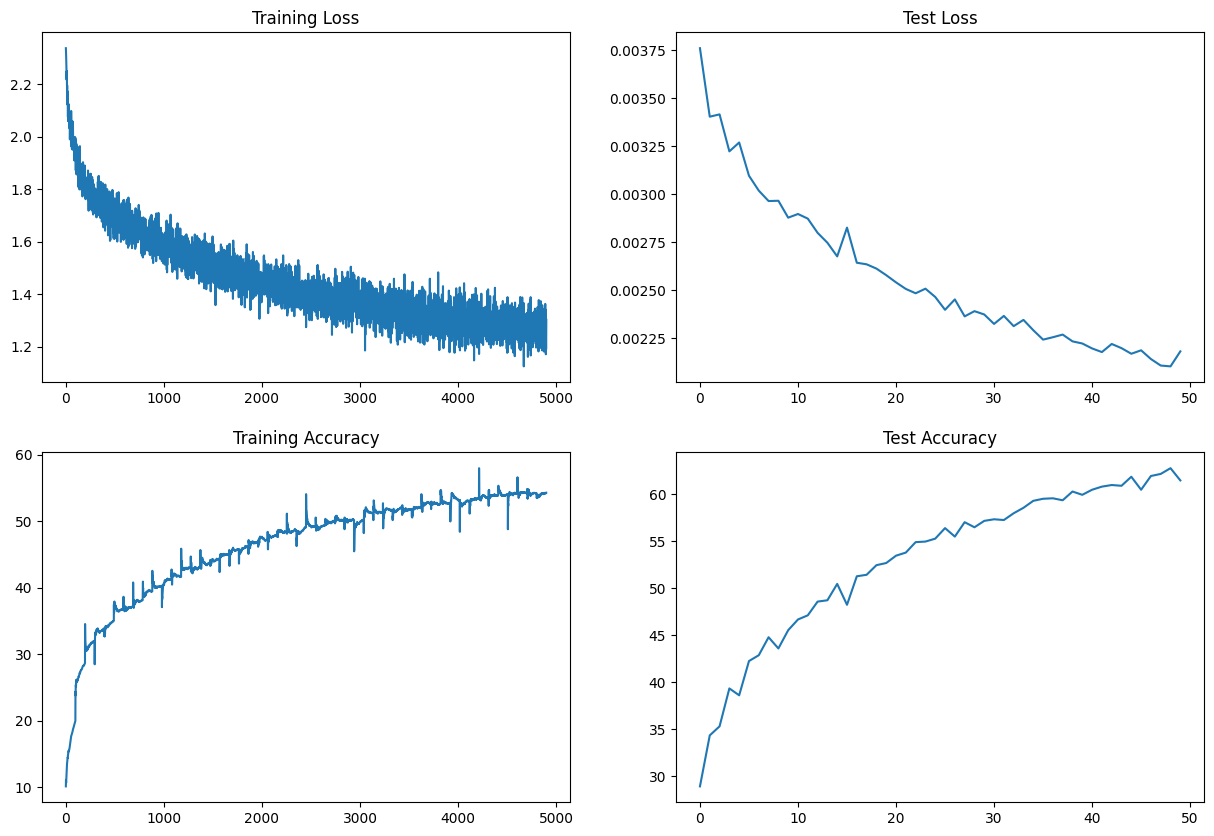

In [10]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# ModeL with MP


$\delta$ `updates:`

- model used earlier above 44 rf
- use MP(k=2,s=2)
- epoch 20
- no aug
- few params

In [11]:
class Net2(nn.Module):
        def __init__(self,channels:list,dp_rate=0.1):
            super(Net2,self).__init__()
            self.dp_rate=dp_rate

            self.C1 = ConvLayer( inc=channels[0] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C2 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C3 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.t1 = nn.Sequential(
                nn.Conv2d(in_channels=channels[1] ,out_channels=channels[1] ,kernel_size=1,padding=0,bias=False),
                nn.MaxPool2d(kernel_size=2,stride=2)
            )

            self.C4 = ConvLayer(inc=channels[1], outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C5 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C6 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.t2 = nn.Sequential(
                nn.Conv2d(in_channels=channels[2] ,out_channels=channels[2] ,kernel_size=1,padding=0,bias=False),
                nn.MaxPool2d(kernel_size=2,stride=2)
            )

            self.C7 = ConvLayer(inc=channels[2] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C8 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C9 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.t3 = nn.Sequential(
                nn.Conv2d(in_channels=channels[3] ,out_channels=channels[3] ,kernel_size=1,padding=0,bias=False),
            )
            
            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            self.out = TransBlock(inc=channels[3] ,outc=channels[4] ,p=0)
            
        def forward(self,x):
            x = self.C1(x)
            x = self.C2(x)
            x = self.C3(x)
            x = self.t1(x)

            x = self.C4(x)
            x = self.C5(x)
            x = self.C6(x)
            x = self.t2(x)

            x = self.C7(x)
            x = self.C8(x)
            x = self.C9(x)
            x = self.t3(x)
            
            x = self.gap(x)
            x = self.out(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [12]:
model2 = Net2(channels=[3,8,16,32,10] , dp_rate=0.15)
summary(model=model2,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net2                                     [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─ConvLayer: 1-2                         [1, 8, 32, 32]            --
│    └─Sequential: 2-2                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            576
│    │    └─BatchNorm2d: 3-6             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-7                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-8               [1, 8, 32, 32]            --
├─ConvLayer: 

In [13]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model2.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model2, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model2, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model2.state_dict(),f='./bmodels/model2.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.93 | Batch = 97 | Accuracy = 20.88: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.72it/s]


Test set: Average loss: 0.0040, Accuracy: 2372/10000 (23.72%)


EPOCH = 2 | LR = 0.1 | Loss = 1.80 | Batch = 97 | Accuracy = 28.29: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0035, Accuracy: 3219/10000 (32.19%)


EPOCH = 3 | LR = 0.1 | Loss = 1.72 | Batch = 97 | Accuracy = 32.22: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0033, Accuracy: 3791/10000 (37.91%)


EPOCH = 4 | LR = 0.1 | Loss = 1.79 | Batch = 97 | Accuracy = 34.85: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0032, Accuracy: 4144/10000 (41.44%)


EPOCH = 5 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 37.54: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0031, Accuracy: 4415/10000 (44.15%)


EPOCH = 6 | LR = 0.1 | Loss = 1.63 | Batch = 97 | Accuracy = 38.78: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0030, Accuracy: 4421/10000 (44.21%)


EPOCH = 7 | LR = 0.1 | Loss = 1.66 | Batch = 97 | Accuracy = 40.25: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0029, Accuracy: 4652/10000 (46.52%)


EPOCH = 8 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 41.40: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0029, Accuracy: 4610/10000 (46.10%)


EPOCH = 9 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 42.67: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0029, Accuracy: 4768/10000 (47.68%)


EPOCH = 10 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 43.60: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0027, Accuracy: 5016/10000 (50.16%)


EPOCH = 11 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 44.59: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.66it/s]


Test set: Average loss: 0.0027, Accuracy: 5166/10000 (51.66%)


EPOCH = 12 | LR = 0.1 | Loss = 1.52 | Batch = 97 | Accuracy = 45.39: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0027, Accuracy: 5123/10000 (51.23%)


EPOCH = 13 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 46.47: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0026, Accuracy: 5370/10000 (53.70%)


EPOCH = 14 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 47.43: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0026, Accuracy: 5239/10000 (52.39%)


EPOCH = 15 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 47.89: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0025, Accuracy: 5481/10000 (54.81%)


EPOCH = 16 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 48.87: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0026, Accuracy: 5399/10000 (53.99%)


EPOCH = 17 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 49.25: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.61it/s]


Test set: Average loss: 0.0024, Accuracy: 5530/10000 (55.30%)


EPOCH = 18 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 49.89: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0025, Accuracy: 5542/10000 (55.42%)


EPOCH = 19 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 50.46: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0024, Accuracy: 5722/10000 (57.22%)


EPOCH = 20 | LR = 0.1 | Loss = 1.31 | Batch = 97 | Accuracy = 50.56: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0024, Accuracy: 5675/10000 (56.75%)


EPOCH = 21 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 51.42: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0023, Accuracy: 5847/10000 (58.47%)


EPOCH = 22 | LR = 0.1 | Loss = 1.31 | Batch = 97 | Accuracy = 51.96: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.72it/s]


Test set: Average loss: 0.0023, Accuracy: 5870/10000 (58.70%)


EPOCH = 23 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 52.57: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0022, Accuracy: 6038/10000 (60.38%)


EPOCH = 24 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 52.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0023, Accuracy: 6023/10000 (60.23%)


EPOCH = 25 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 53.15: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s]


Test set: Average loss: 0.0023, Accuracy: 5977/10000 (59.77%)


EPOCH = 26 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 53.58: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s]


Test set: Average loss: 0.0022, Accuracy: 6046/10000 (60.46%)


EPOCH = 27 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 53.80: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0022, Accuracy: 6104/10000 (61.04%)


EPOCH = 28 | LR = 0.1 | Loss = 1.33 | Batch = 97 | Accuracy = 53.99: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0021, Accuracy: 6180/10000 (61.80%)


EPOCH = 29 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 54.45: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0021, Accuracy: 6182/10000 (61.82%)


EPOCH = 30 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 54.61: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0021, Accuracy: 6203/10000 (62.03%)


EPOCH = 31 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 55.08: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0022, Accuracy: 6101/10000 (61.01%)


EPOCH = 32 | LR = 0.1 | Loss = 1.18 | Batch = 97 | Accuracy = 55.69: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.81it/s]


Test set: Average loss: 0.0022, Accuracy: 6105/10000 (61.05%)


EPOCH = 33 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 55.43: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0021, Accuracy: 6371/10000 (63.71%)


EPOCH = 34 | LR = 0.1 | Loss = 1.20 | Batch = 97 | Accuracy = 55.57: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0021, Accuracy: 6330/10000 (63.30%)


EPOCH = 35 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 55.92: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0021, Accuracy: 6373/10000 (63.73%)


EPOCH = 36 | LR = 0.1 | Loss = 1.24 | Batch = 97 | Accuracy = 56.12: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0020, Accuracy: 6450/10000 (64.50%)


EPOCH = 37 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 56.29: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0020, Accuracy: 6506/10000 (65.06%)


EPOCH = 38 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 56.74: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0021, Accuracy: 6357/10000 (63.57%)


EPOCH = 39 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 56.49: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0020, Accuracy: 6484/10000 (64.84%)


EPOCH = 40 | LR = 0.1 | Loss = 1.20 | Batch = 97 | Accuracy = 57.34: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0020, Accuracy: 6498/10000 (64.98%)


EPOCH = 41 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 57.00: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.64it/s]


Test set: Average loss: 0.0020, Accuracy: 6432/10000 (64.32%)


EPOCH = 42 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 57.47: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0020, Accuracy: 6575/10000 (65.75%)


EPOCH = 43 | LR = 0.1 | Loss = 1.18 | Batch = 97 | Accuracy = 57.37: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s]


Test set: Average loss: 0.0020, Accuracy: 6383/10000 (63.83%)


EPOCH = 44 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 57.50: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0020, Accuracy: 6500/10000 (65.00%)


EPOCH = 45 | LR = 0.1 | Loss = 1.04 | Batch = 97 | Accuracy = 57.84: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0020, Accuracy: 6539/10000 (65.39%)


EPOCH = 46 | LR = 0.1 | Loss = 1.15 | Batch = 97 | Accuracy = 57.72: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0019, Accuracy: 6582/10000 (65.82%)


EPOCH = 47 | LR = 0.1 | Loss = 1.23 | Batch = 97 | Accuracy = 58.16: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0019, Accuracy: 6606/10000 (66.06%)


EPOCH = 48 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 58.44: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0020, Accuracy: 6557/10000 (65.57%)


EPOCH = 49 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 58.30: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s]


Test set: Average loss: 0.0019, Accuracy: 6580/10000 (65.80%)


EPOCH = 50 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 58.23: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0019, Accuracy: 6583/10000 (65.83%)


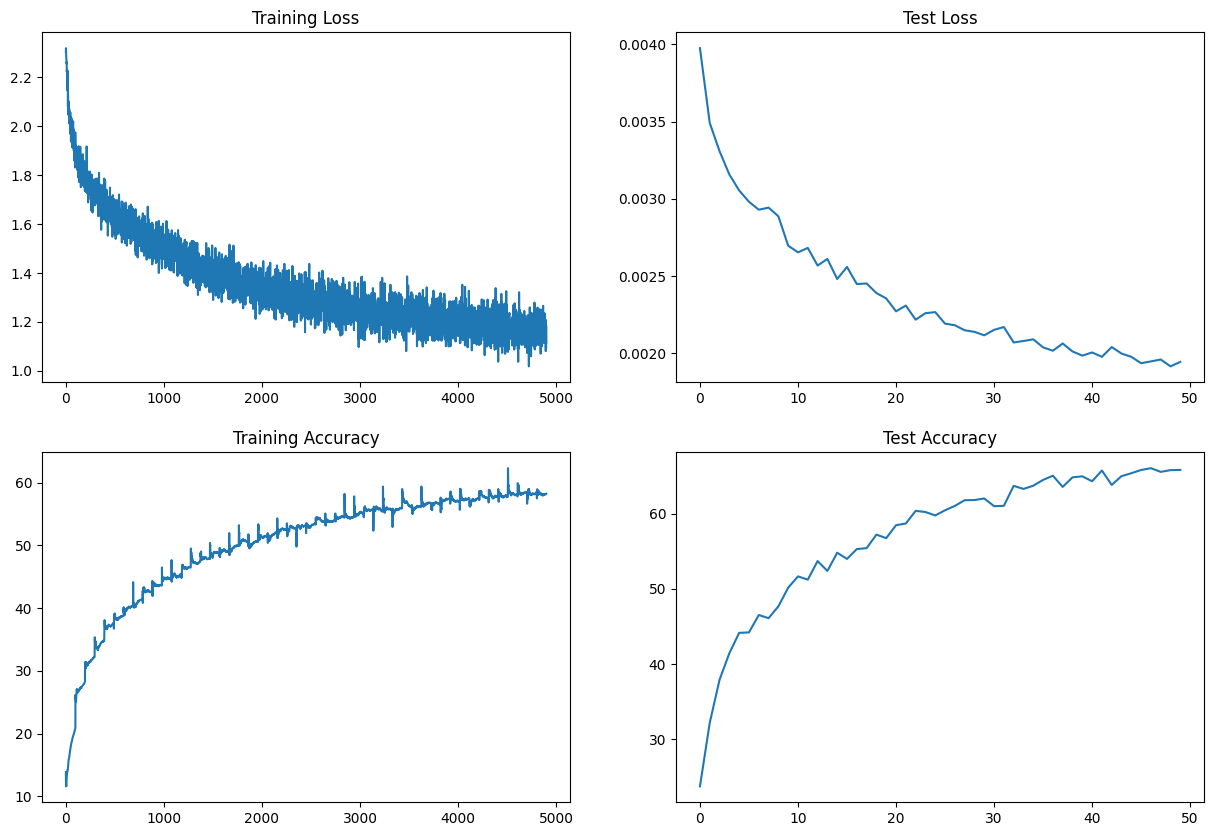

In [14]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# ModeL with resNet cont. addition with MP


$\delta$ `updates:`

- model used earlier above 44 rf
- used MP
- resnet addition
- epoch 20
- no aug
- few params

In [15]:
class Net3(nn.Module):
        def __init__(self,channels:list,dp_rate=0.1):
            super(Net3,self).__init__()
            self.dp_rate=dp_rate

            self.C1 = ConvLayer( inc=channels[0] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C2 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C3 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.t1 = nn.Sequential(
                nn.Conv2d(in_channels=channels[1] ,out_channels=channels[1] ,kernel_size=1,padding=0,bias=False),
                nn.MaxPool2d(kernel_size=2,stride=2)
            )

            self.C4 = ConvLayer(inc=channels[1], outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C5 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C6 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.t2 = nn.Sequential(
                nn.Conv2d(in_channels=channels[2] ,out_channels=channels[2] ,kernel_size=1,padding=0,bias=False),
                nn.MaxPool2d(kernel_size=2,stride=2)
            )

            self.C7 = ConvLayer(inc=channels[2] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C8 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C9 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.t3 = nn.Sequential(
                nn.Conv2d(in_channels=channels[3] ,out_channels=channels[3] ,kernel_size=1,padding=0,bias=False),
            )
            
            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            self.out = TransBlock(inc=channels[3] ,outc=channels[4] ,p=0)
            
        def forward(self,x):
            x = self.C1(x)
            x = x + self.C2(x)
            x = x + self.C3(x)
            x = self.t1(x)

            x = self.C4(x)
            x = x + self.C5(x)
            x = x + self.C6(x)
            x = self.t2(x)

            x = self.C7(x)
            x = x + self.C8(x)
            x = x + self.C9(x)
            x = self.t3(x)
            
            x = self.gap(x)
            x = self.out(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [16]:
model3 = Net3(channels=[3,8,16,32,10],dp_rate=0.15)
summary(model=model3,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net3                                     [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─ConvLayer: 1-2                         [1, 8, 32, 32]            --
│    └─Sequential: 2-2                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            576
│    │    └─BatchNorm2d: 3-6             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-7                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-8               [1, 8, 32, 32]            --
├─ConvLayer: 

In [17]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model3.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model3, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model3, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model3.state_dict(),f='./bmodels/model3.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.71 | Batch = 97 | Accuracy = 26.10: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.72it/s]


Test set: Average loss: 0.0035, Accuracy: 3355/10000 (33.55%)


EPOCH = 2 | LR = 0.1 | Loss = 1.65 | Batch = 97 | Accuracy = 37.62: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0028, Accuracy: 4789/10000 (47.89%)


EPOCH = 3 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 43.73: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0028, Accuracy: 4806/10000 (48.06%)


EPOCH = 4 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 47.11: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0026, Accuracy: 5163/10000 (51.63%)


EPOCH = 5 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 49.55: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0027, Accuracy: 5291/10000 (52.91%)


EPOCH = 6 | LR = 0.1 | Loss = 1.33 | Batch = 97 | Accuracy = 51.84: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0024, Accuracy: 5672/10000 (56.72%)


EPOCH = 7 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 53.62: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0023, Accuracy: 5853/10000 (58.53%)


EPOCH = 8 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 54.74: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0022, Accuracy: 6043/10000 (60.43%)


EPOCH = 9 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 55.86: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.66it/s]


Test set: Average loss: 0.0022, Accuracy: 6094/10000 (60.94%)


EPOCH = 10 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 56.87: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0022, Accuracy: 6023/10000 (60.23%)


EPOCH = 11 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 57.50: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0022, Accuracy: 5966/10000 (59.66%)


EPOCH = 12 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 58.55: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0021, Accuracy: 6125/10000 (61.25%)


EPOCH = 13 | LR = 0.1 | Loss = 1.15 | Batch = 97 | Accuracy = 59.56: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0024, Accuracy: 5692/10000 (56.92%)


EPOCH = 14 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 60.32: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0022, Accuracy: 6106/10000 (61.06%)


EPOCH = 15 | LR = 0.1 | Loss = 1.01 | Batch = 97 | Accuracy = 60.87: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0020, Accuracy: 6435/10000 (64.35%)


EPOCH = 16 | LR = 0.1 | Loss = 0.99 | Batch = 97 | Accuracy = 61.41: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0022, Accuracy: 6106/10000 (61.06%)


EPOCH = 17 | LR = 0.1 | Loss = 1.04 | Batch = 97 | Accuracy = 61.64: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0019, Accuracy: 6570/10000 (65.70%)


EPOCH = 18 | LR = 0.1 | Loss = 1.06 | Batch = 97 | Accuracy = 62.43: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0020, Accuracy: 6597/10000 (65.97%)


EPOCH = 19 | LR = 0.1 | Loss = 0.97 | Batch = 97 | Accuracy = 62.32: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0020, Accuracy: 6457/10000 (64.57%)


EPOCH = 20 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 63.13: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0020, Accuracy: 6398/10000 (63.98%)


EPOCH = 21 | LR = 0.1 | Loss = 1.08 | Batch = 97 | Accuracy = 63.36: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0020, Accuracy: 6541/10000 (65.41%)


EPOCH = 22 | LR = 0.010000000000000002 | Loss = 0.97 | Batch = 97 | Accuracy = 65.12: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0019, Accuracy: 6711/10000 (67.11%)


EPOCH = 23 | LR = 0.010000000000000002 | Loss = 0.92 | Batch = 97 | Accuracy = 65.50: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0018, Accuracy: 6766/10000 (67.66%)


EPOCH = 24 | LR = 0.010000000000000002 | Loss = 0.92 | Batch = 97 | Accuracy = 65.85: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.69it/s]


Test set: Average loss: 0.0018, Accuracy: 6713/10000 (67.13%)


EPOCH = 25 | LR = 0.010000000000000002 | Loss = 0.98 | Batch = 97 | Accuracy = 66.00: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0019, Accuracy: 6702/10000 (67.02%)


EPOCH = 26 | LR = 0.010000000000000002 | Loss = 0.96 | Batch = 97 | Accuracy = 65.90: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0018, Accuracy: 6752/10000 (67.52%)


EPOCH = 27 | LR = 0.010000000000000002 | Loss = 0.97 | Batch = 97 | Accuracy = 66.31: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.74it/s]


Test set: Average loss: 0.0019, Accuracy: 6728/10000 (67.28%)


EPOCH = 28 | LR = 0.0010000000000000002 | Loss = 0.85 | Batch = 97 | Accuracy = 66.16: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0018, Accuracy: 6726/10000 (67.26%)


EPOCH = 29 | LR = 0.0010000000000000002 | Loss = 0.93 | Batch = 97 | Accuracy = 66.18: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0018, Accuracy: 6750/10000 (67.50%)


EPOCH = 30 | LR = 0.0010000000000000002 | Loss = 0.96 | Batch = 97 | Accuracy = 66.09: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0018, Accuracy: 6757/10000 (67.57%)


EPOCH = 31 | LR = 0.0010000000000000002 | Loss = 0.89 | Batch = 97 | Accuracy = 66.52: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0018, Accuracy: 6763/10000 (67.63%)


EPOCH = 32 | LR = 0.0010000000000000002 | Loss = 0.88 | Batch = 97 | Accuracy = 66.52: 100%|█████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0018, Accuracy: 6744/10000 (67.44%)


EPOCH = 33 | LR = 0.0010000000000000002 | Loss = 0.91 | Batch = 97 | Accuracy = 66.29: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0018, Accuracy: 6765/10000 (67.65%)


EPOCH = 34 | LR = 0.0010000000000000002 | Loss = 1.00 | Batch = 97 | Accuracy = 66.35: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0018, Accuracy: 6733/10000 (67.33%)


EPOCH = 35 | LR = 0.0010000000000000002 | Loss = 0.82 | Batch = 97 | Accuracy = 66.47: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0018, Accuracy: 6736/10000 (67.36%)


EPOCH = 36 | LR = 0.0010000000000000002 | Loss = 0.85 | Batch = 97 | Accuracy = 66.26: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.77it/s]


Test set: Average loss: 0.0018, Accuracy: 6765/10000 (67.65%)


EPOCH = 37 | LR = 0.0010000000000000002 | Loss = 0.90 | Batch = 97 | Accuracy = 66.31: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.74it/s]


Test set: Average loss: 0.0018, Accuracy: 6773/10000 (67.73%)


EPOCH = 38 | LR = 0.0010000000000000002 | Loss = 0.83 | Batch = 97 | Accuracy = 66.37: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0018, Accuracy: 6749/10000 (67.49%)


EPOCH = 39 | LR = 0.0010000000000000002 | Loss = 0.98 | Batch = 97 | Accuracy = 66.65: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.74it/s]


Test set: Average loss: 0.0018, Accuracy: 6775/10000 (67.75%)


EPOCH = 40 | LR = 0.0010000000000000002 | Loss = 1.03 | Batch = 97 | Accuracy = 66.28: 100%|█████████████████████████████████████████████| 98/98 [00:26<00:00,  3.66it/s]


Test set: Average loss: 0.0018, Accuracy: 6774/10000 (67.74%)


EPOCH = 41 | LR = 0.0010000000000000002 | Loss = 0.87 | Batch = 97 | Accuracy = 66.12: 100%|█████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0018, Accuracy: 6749/10000 (67.49%)


EPOCH = 42 | LR = 0.00010000000000000003 | Loss = 0.87 | Batch = 97 | Accuracy = 66.57: 100%|████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0018, Accuracy: 6760/10000 (67.60%)


EPOCH = 43 | LR = 0.00010000000000000003 | Loss = 0.97 | Batch = 97 | Accuracy = 66.65: 100%|████████████████████████████████████████████| 98/98 [00:27<00:00,  3.59it/s]


Test set: Average loss: 0.0018, Accuracy: 6784/10000 (67.84%)


EPOCH = 44 | LR = 0.00010000000000000003 | Loss = 0.86 | Batch = 97 | Accuracy = 66.58: 100%|████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0018, Accuracy: 6750/10000 (67.50%)


EPOCH = 45 | LR = 0.00010000000000000003 | Loss = 0.89 | Batch = 97 | Accuracy = 66.35: 100%|████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0018, Accuracy: 6745/10000 (67.45%)


EPOCH = 46 | LR = 1.0000000000000004e-05 | Loss = 0.89 | Batch = 97 | Accuracy = 66.31: 100%|████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0018, Accuracy: 6758/10000 (67.58%)


EPOCH = 47 | LR = 1.0000000000000004e-05 | Loss = 0.95 | Batch = 97 | Accuracy = 66.61: 100%|████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0018, Accuracy: 6759/10000 (67.59%)


EPOCH = 48 | LR = 1.0000000000000004e-05 | Loss = 0.91 | Batch = 97 | Accuracy = 66.43: 100%|████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0018, Accuracy: 6732/10000 (67.32%)


EPOCH = 49 | LR = 1.0000000000000004e-05 | Loss = 0.89 | Batch = 97 | Accuracy = 66.64: 100%|████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0018, Accuracy: 6770/10000 (67.70%)


EPOCH = 50 | LR = 1.0000000000000004e-06 | Loss = 0.82 | Batch = 97 | Accuracy = 66.47: 100%|████████████████████████████████████████████| 98/98 [00:25<00:00,  3.77it/s]


Test set: Average loss: 0.0018, Accuracy: 6746/10000 (67.46%)


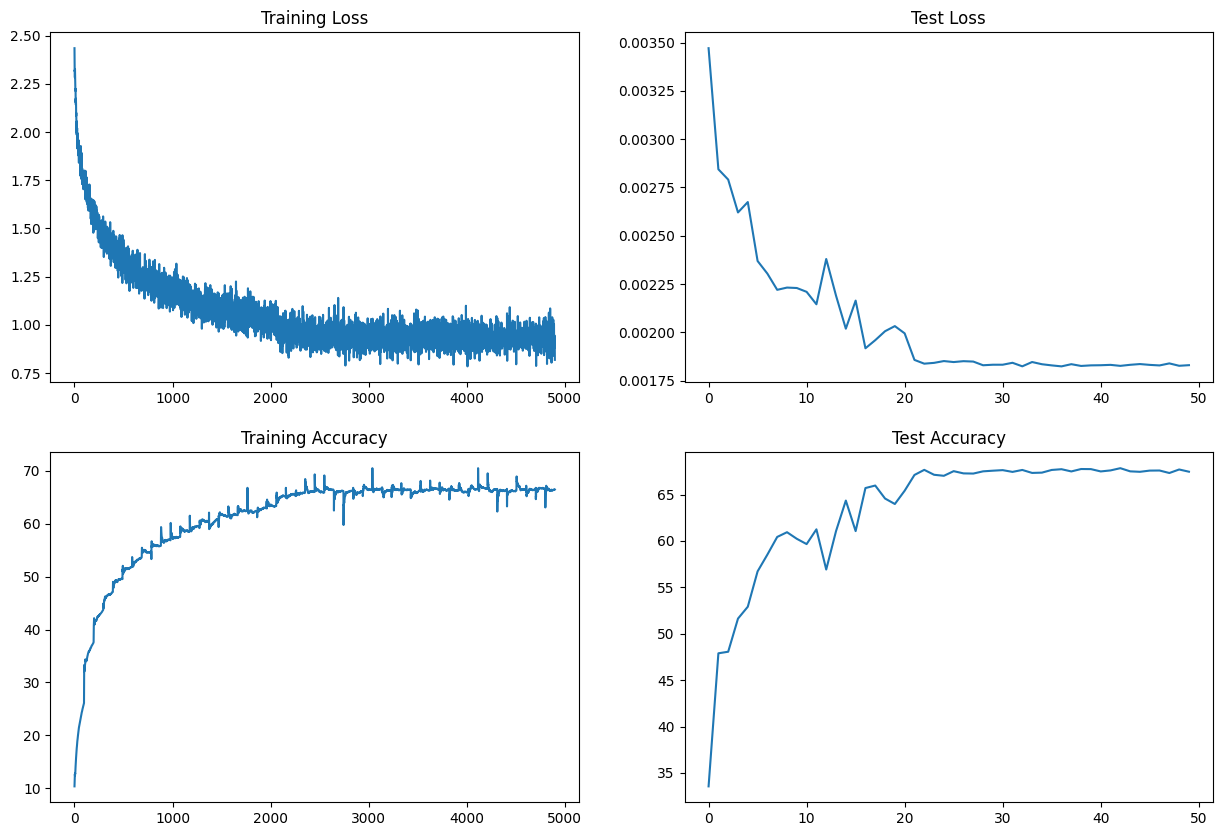

In [18]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# ModeL with resNet cont. addition without MP



$\delta$ `updates:`

- model used earlier above 44 rf
- instead of MP replace stride=2 in $3^{rd}$ layer of every Conv block
- epoch 20
- no aug
- few params

In [19]:
class Net4(nn.Module):
        def __init__(self,channels:list,dp_rate=0.1):
            super(Net4,self).__init__()
            self.dp_rate=dp_rate

            self.C1 = ConvLayer( inc=channels[0] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C2 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C3 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)
            self.t1 = TransBlock(inc=channels[1] ,outc=channels[1] ,p=0)

            self.C4 = ConvLayer(inc=channels[1], outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C5 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C6 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)
            self.t2 = TransBlock(inc=channels[2] ,outc=channels[2] ,p=0)

            self.C7 = ConvLayer(inc=channels[2] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C8 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C9 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)

            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            self.out = TransBlock(inc=channels[3] ,outc=channels[4] ,p=0)
            
        def forward(self,x):
            x = self.C1(x)
            x = x + self.C2(x)
            x = self.C3(x)
            x = x + self.t1(x)

            x = self.C4(x)
            x = x + self.C5(x)
            x = self.C6(x)
            x = x + self.t2(x)
            

            x = self.C7(x)
            x = x + self.C8(x)
            x = self.C9(x)

            x = self.gap(x)
            x = self.out(x)
            return F.log_softmax(x.view(-1,10), dim=1)


model4 = Net4(channels=[3,8,16,32,10],dp_rate=0.15)
summary(model=model4,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net4                                     [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─ConvLayer: 1-2                         [1, 8, 32, 32]            --
│    └─Sequential: 2-2                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            576
│    │    └─BatchNorm2d: 3-6             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-7                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-8               [1, 8, 32, 32]            --
├─ConvLayer: 

In [20]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model4.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model4, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model4, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model4.state_dict(),f='./bmodels/model4.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.94 | Batch = 97 | Accuracy = 22.95: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.88it/s]


Test set: Average loss: 0.0036, Accuracy: 3238/10000 (32.38%)


EPOCH = 2 | LR = 0.1 | Loss = 1.74 | Batch = 97 | Accuracy = 31.23: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0033, Accuracy: 3974/10000 (39.74%)


EPOCH = 3 | LR = 0.1 | Loss = 1.70 | Batch = 97 | Accuracy = 35.70: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0032, Accuracy: 4196/10000 (41.96%)


EPOCH = 4 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 37.97: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0030, Accuracy: 4432/10000 (44.32%)


EPOCH = 5 | LR = 0.1 | Loss = 1.52 | Batch = 97 | Accuracy = 39.86: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0030, Accuracy: 4459/10000 (44.59%)


EPOCH = 6 | LR = 0.1 | Loss = 1.61 | Batch = 97 | Accuracy = 41.39: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.78it/s]


Test set: Average loss: 0.0028, Accuracy: 4812/10000 (48.12%)


EPOCH = 7 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 43.29: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0028, Accuracy: 4849/10000 (48.49%)


EPOCH = 8 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 44.37: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0027, Accuracy: 5103/10000 (51.03%)


EPOCH = 9 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 45.57: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0026, Accuracy: 5237/10000 (52.37%)


EPOCH = 10 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 46.67: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.88it/s]


Test set: Average loss: 0.0025, Accuracy: 5449/10000 (54.49%)


EPOCH = 11 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 47.54: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0025, Accuracy: 5475/10000 (54.75%)


EPOCH = 12 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 48.29: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0025, Accuracy: 5508/10000 (55.08%)


EPOCH = 13 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 49.31: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.88it/s]


Test set: Average loss: 0.0025, Accuracy: 5590/10000 (55.90%)


EPOCH = 14 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 50.50: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0024, Accuracy: 5812/10000 (58.12%)


EPOCH = 15 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 50.67: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.81it/s]


Test set: Average loss: 0.0024, Accuracy: 5740/10000 (57.40%)


EPOCH = 16 | LR = 0.1 | Loss = 1.33 | Batch = 97 | Accuracy = 51.44: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0023, Accuracy: 5845/10000 (58.45%)


EPOCH = 17 | LR = 0.1 | Loss = 1.33 | Batch = 97 | Accuracy = 51.92: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0023, Accuracy: 5898/10000 (58.98%)


EPOCH = 18 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 52.64: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.80it/s]


Test set: Average loss: 0.0023, Accuracy: 5864/10000 (58.64%)


EPOCH = 19 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 52.91: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s]


Test set: Average loss: 0.0023, Accuracy: 5793/10000 (57.93%)


EPOCH = 20 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 53.40: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0023, Accuracy: 6011/10000 (60.11%)


EPOCH = 21 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 54.05: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0022, Accuracy: 6041/10000 (60.41%)


EPOCH = 22 | LR = 0.1 | Loss = 1.23 | Batch = 97 | Accuracy = 53.83: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.88it/s]


Test set: Average loss: 0.0022, Accuracy: 6048/10000 (60.48%)


EPOCH = 23 | LR = 0.1 | Loss = 1.23 | Batch = 97 | Accuracy = 54.43: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0022, Accuracy: 6129/10000 (61.29%)


EPOCH = 24 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 54.33: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.88it/s]


Test set: Average loss: 0.0022, Accuracy: 6081/10000 (60.81%)


EPOCH = 25 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 55.21: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0022, Accuracy: 6115/10000 (61.15%)


EPOCH = 26 | LR = 0.1 | Loss = 1.22 | Batch = 97 | Accuracy = 55.47: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.87it/s]


Test set: Average loss: 0.0021, Accuracy: 6192/10000 (61.92%)


EPOCH = 27 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 55.89: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0022, Accuracy: 6167/10000 (61.67%)


EPOCH = 28 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 56.10: 100%|███████████████████████████████████████████████████████████████| 98/98 [03:07<00:00,  1.91s/it]


Test set: Average loss: 0.0021, Accuracy: 6311/10000 (63.11%)


EPOCH = 29 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 56.44: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.86it/s]


Test set: Average loss: 0.0021, Accuracy: 6290/10000 (62.90%)


EPOCH = 30 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 56.44: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0021, Accuracy: 6349/10000 (63.49%)


EPOCH = 31 | LR = 0.1 | Loss = 1.20 | Batch = 97 | Accuracy = 56.74: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0021, Accuracy: 6252/10000 (62.52%)


EPOCH = 32 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 57.21: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0020, Accuracy: 6411/10000 (64.11%)


EPOCH = 33 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 57.49: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0020, Accuracy: 6411/10000 (64.11%)


EPOCH = 34 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 57.40: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0020, Accuracy: 6478/10000 (64.78%)


EPOCH = 35 | LR = 0.1 | Loss = 1.24 | Batch = 97 | Accuracy = 57.56: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0020, Accuracy: 6401/10000 (64.01%)


EPOCH = 36 | LR = 0.1 | Loss = 1.07 | Batch = 97 | Accuracy = 57.94: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0020, Accuracy: 6496/10000 (64.96%)


EPOCH = 37 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 58.44: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0020, Accuracy: 6438/10000 (64.38%)


EPOCH = 38 | LR = 0.1 | Loss = 1.16 | Batch = 97 | Accuracy = 58.51: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0020, Accuracy: 6547/10000 (65.47%)


EPOCH = 39 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 58.51: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0020, Accuracy: 6495/10000 (64.95%)


EPOCH = 40 | LR = 0.1 | Loss = 1.18 | Batch = 97 | Accuracy = 58.43: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.81it/s]


Test set: Average loss: 0.0020, Accuracy: 6543/10000 (65.43%)


EPOCH = 41 | LR = 0.1 | Loss = 1.18 | Batch = 97 | Accuracy = 58.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0019, Accuracy: 6688/10000 (66.88%)


EPOCH = 42 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 59.00: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0020, Accuracy: 6560/10000 (65.60%)


EPOCH = 43 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 59.11: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.86it/s]


Test set: Average loss: 0.0019, Accuracy: 6649/10000 (66.49%)


EPOCH = 44 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 59.08: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0019, Accuracy: 6615/10000 (66.15%)


EPOCH = 45 | LR = 0.1 | Loss = 1.13 | Batch = 97 | Accuracy = 59.04: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0019, Accuracy: 6688/10000 (66.88%)


EPOCH = 46 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 59.09: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0019, Accuracy: 6701/10000 (67.01%)


EPOCH = 47 | LR = 0.1 | Loss = 1.10 | Batch = 97 | Accuracy = 59.54: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0020, Accuracy: 6485/10000 (64.85%)


EPOCH = 48 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 60.06: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0019, Accuracy: 6701/10000 (67.01%)


EPOCH = 49 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 59.71: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0019, Accuracy: 6683/10000 (66.83%)


EPOCH = 50 | LR = 0.1 | Loss = 1.23 | Batch = 97 | Accuracy = 59.81: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0019, Accuracy: 6708/10000 (67.08%)


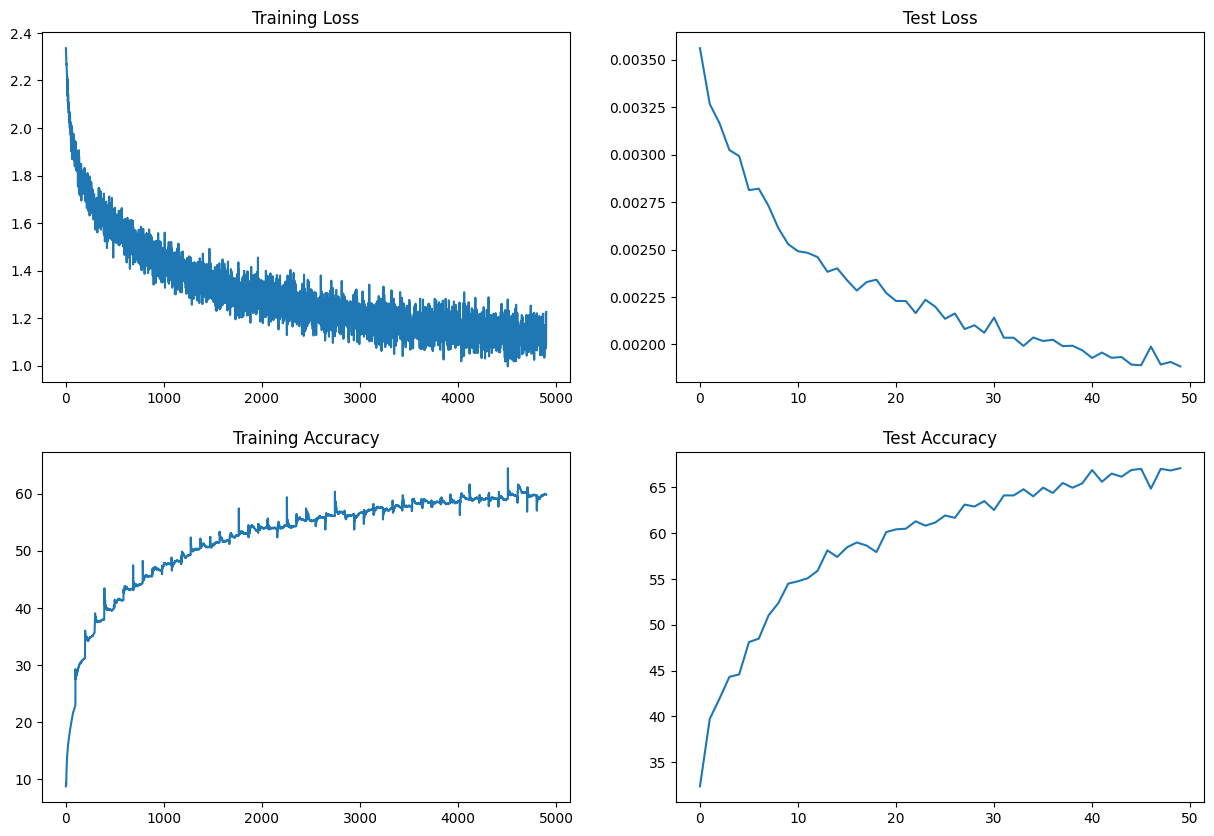

In [21]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# ModeL not additing with TransBlock 

`updates`:

- previous model with small change in transblock

In [22]:
class Net5(nn.Module):
        def __init__(self,channels:list,dp_rate=0.1):
            super(Net5,self).__init__()
            self.dp_rate=dp_rate

            self.C1 = ConvLayer( inc=channels[0] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C2 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C3 = ConvLayer(inc=channels[1] ,outc=channels[1] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)
            self.t1 = TransBlock(inc=channels[1] ,outc=channels[1] ,p=0)

            self.C4 = ConvLayer(inc=channels[1], outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C5 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C6 = ConvLayer(inc=channels[2] ,outc=channels[2] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)
            self.t2 = TransBlock(inc=channels[2] ,outc=channels[2] ,p=0)

            self.C7 = ConvLayer(inc=channels[2] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C8 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=1,d=1,dp_rate=self.dp_rate)
            self.C9 = ConvLayer(inc=channels[3] ,outc=channels[3] ,k=3,p=1,s=2,d=1,dp_rate=self.dp_rate)

            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            self.out = TransBlock(inc=channels[3] ,outc=channels[4] ,p=0)
            
        def forward(self,x):
            x = self.C1(x)
            x = x + self.C2(x)
            x = self.C3(x)
            x = self.t1(x)

            x = self.C4(x)
            x = x + self.C5(x)
            x = self.C6(x)
            x = self.t2(x)
            

            x = self.C7(x)
            x = x + self.C8(x)
            x = self.C9(x)

            x = self.gap(x)
            x = self.out(x)
            return F.log_softmax(x.view(-1,10), dim=1)


model5 = Net5(channels=[3,8,16,32,10],dp_rate=0.15)
summary(model=model5,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net5                                     [1, 10]                   --
├─ConvLayer: 1-1                         [1, 8, 32, 32]            --
│    └─Sequential: 2-1                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-1                  [1, 8, 32, 32]            216
│    │    └─BatchNorm2d: 3-2             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-3                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-4               [1, 8, 32, 32]            --
├─ConvLayer: 1-2                         [1, 8, 32, 32]            --
│    └─Sequential: 2-2                   [1, 8, 32, 32]            --
│    │    └─Conv2d: 3-5                  [1, 8, 32, 32]            576
│    │    └─BatchNorm2d: 3-6             [1, 8, 32, 32]            16
│    │    └─ReLU: 3-7                    [1, 8, 32, 32]            --
│    │    └─Dropout2d: 3-8               [1, 8, 32, 32]            --
├─ConvLayer: 

In [23]:

prev_test_loss = float('inf')

optimizer = optim.SGD(params=model5.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model5, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model5, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model5.state_dict(),f='./bmodels/model5.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.91 | Batch = 97 | Accuracy = 23.60: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.81it/s]


Test set: Average loss: 0.0035, Accuracy: 3537/10000 (35.37%)


EPOCH = 2 | LR = 0.1 | Loss = 1.69 | Batch = 97 | Accuracy = 31.74: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s]


Test set: Average loss: 0.0032, Accuracy: 3844/10000 (38.44%)


EPOCH = 3 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 35.43: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0031, Accuracy: 4220/10000 (42.20%)


EPOCH = 4 | LR = 0.1 | Loss = 1.67 | Batch = 97 | Accuracy = 38.29: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0030, Accuracy: 4386/10000 (43.86%)


EPOCH = 5 | LR = 0.1 | Loss = 1.59 | Batch = 97 | Accuracy = 40.22: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0029, Accuracy: 4527/10000 (45.27%)


EPOCH = 6 | LR = 0.1 | Loss = 1.57 | Batch = 97 | Accuracy = 42.03: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0028, Accuracy: 4869/10000 (48.69%)


EPOCH = 7 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 43.17: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s]


Test set: Average loss: 0.0028, Accuracy: 4885/10000 (48.85%)


EPOCH = 8 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 44.35: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0027, Accuracy: 5145/10000 (51.45%)


EPOCH = 9 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 45.56: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0027, Accuracy: 5118/10000 (51.18%)


EPOCH = 10 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 46.20: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0026, Accuracy: 5254/10000 (52.54%)


EPOCH = 11 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 47.21: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.78it/s]


Test set: Average loss: 0.0026, Accuracy: 5439/10000 (54.39%)


EPOCH = 12 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 48.31: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.79it/s]


Test set: Average loss: 0.0025, Accuracy: 5454/10000 (54.54%)


EPOCH = 13 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 48.66: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0025, Accuracy: 5578/10000 (55.78%)


EPOCH = 14 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 49.54: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0025, Accuracy: 5526/10000 (55.26%)


EPOCH = 15 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 50.09: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0024, Accuracy: 5617/10000 (56.17%)


EPOCH = 16 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 50.64: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0024, Accuracy: 5676/10000 (56.76%)


EPOCH = 17 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 50.85: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.80it/s]


Test set: Average loss: 0.0023, Accuracy: 5827/10000 (58.27%)


EPOCH = 18 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 51.79: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0023, Accuracy: 5898/10000 (58.98%)


EPOCH = 19 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 51.71: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0023, Accuracy: 5968/10000 (59.68%)


EPOCH = 20 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 52.38: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0023, Accuracy: 6009/10000 (60.09%)


EPOCH = 21 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 52.79: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.83it/s]


Test set: Average loss: 0.0023, Accuracy: 5859/10000 (58.59%)


EPOCH = 22 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 53.12: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.81it/s]


Test set: Average loss: 0.0022, Accuracy: 6045/10000 (60.45%)


EPOCH = 23 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 53.83: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0023, Accuracy: 5804/10000 (58.04%)


EPOCH = 24 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 53.78: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0023, Accuracy: 6000/10000 (60.00%)


EPOCH = 25 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 54.00: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0023, Accuracy: 5985/10000 (59.85%)


EPOCH = 26 | LR = 0.1 | Loss = 1.39 | Batch = 97 | Accuracy = 54.47: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.65it/s]


Test set: Average loss: 0.0022, Accuracy: 6158/10000 (61.58%)


EPOCH = 27 | LR = 0.1 | Loss = 1.20 | Batch = 97 | Accuracy = 54.68: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0022, Accuracy: 6155/10000 (61.55%)


EPOCH = 28 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 55.08: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.74it/s]


Test set: Average loss: 0.0022, Accuracy: 6005/10000 (60.05%)


EPOCH = 29 | LR = 0.1 | Loss = 1.25 | Batch = 97 | Accuracy = 54.91: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.80it/s]


Test set: Average loss: 0.0021, Accuracy: 6262/10000 (62.62%)


EPOCH = 30 | LR = 0.1 | Loss = 1.25 | Batch = 97 | Accuracy = 55.35: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0022, Accuracy: 6177/10000 (61.77%)


EPOCH = 31 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 55.37: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.73it/s]


Test set: Average loss: 0.0022, Accuracy: 6197/10000 (61.97%)


EPOCH = 32 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 55.71: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:25<00:00,  3.82it/s]


Test set: Average loss: 0.0021, Accuracy: 6213/10000 (62.13%)


EPOCH = 33 | LR = 0.1 | Loss = 1.17 | Batch = 97 | Accuracy = 55.74: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.75it/s]


Test set: Average loss: 0.0022, Accuracy: 6182/10000 (61.82%)


EPOCH = 34 | LR = 0.010000000000000002 | Loss = 1.11 | Batch = 97 | Accuracy = 56.80: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.56it/s]


Test set: Average loss: 0.0021, Accuracy: 6316/10000 (63.16%)


EPOCH = 35 | LR = 0.010000000000000002 | Loss = 1.12 | Batch = 97 | Accuracy = 57.66: 100%|██████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0021, Accuracy: 6365/10000 (63.65%)


EPOCH = 36 | LR = 0.010000000000000002 | Loss = 1.25 | Batch = 97 | Accuracy = 57.52: 100%|██████████████████████████████████████████████| 98/98 [00:25<00:00,  3.83it/s]


Test set: Average loss: 0.0021, Accuracy: 6347/10000 (63.47%)


EPOCH = 37 | LR = 0.010000000000000002 | Loss = 1.21 | Batch = 97 | Accuracy = 57.70: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0021, Accuracy: 6329/10000 (63.29%)


EPOCH = 38 | LR = 0.010000000000000002 | Loss = 1.15 | Batch = 97 | Accuracy = 57.63: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0021, Accuracy: 6327/10000 (63.27%)


EPOCH = 39 | LR = 0.010000000000000002 | Loss = 1.19 | Batch = 97 | Accuracy = 57.77: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.56it/s]


Test set: Average loss: 0.0021, Accuracy: 6365/10000 (63.65%)


EPOCH = 40 | LR = 0.010000000000000002 | Loss = 1.09 | Batch = 97 | Accuracy = 58.10: 100%|██████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0021, Accuracy: 6371/10000 (63.71%)


EPOCH = 41 | LR = 0.010000000000000002 | Loss = 1.10 | Batch = 97 | Accuracy = 57.98: 100%|██████████████████████████████████████████████| 98/98 [00:25<00:00,  3.91it/s]


Test set: Average loss: 0.0020, Accuracy: 6413/10000 (64.13%)


EPOCH = 42 | LR = 0.010000000000000002 | Loss = 1.16 | Batch = 97 | Accuracy = 57.95: 100%|██████████████████████████████████████████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 0.0021, Accuracy: 6382/10000 (63.82%)


EPOCH = 43 | LR = 0.010000000000000002 | Loss = 1.18 | Batch = 97 | Accuracy = 57.81: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.76it/s]


Test set: Average loss: 0.0020, Accuracy: 6384/10000 (63.84%)


EPOCH = 44 | LR = 0.010000000000000002 | Loss = 1.12 | Batch = 97 | Accuracy = 58.15: 100%|██████████████████████████████████████████████| 98/98 [00:25<00:00,  3.84it/s]


Test set: Average loss: 0.0021, Accuracy: 6410/10000 (64.10%)


EPOCH = 45 | LR = 0.010000000000000002 | Loss = 1.10 | Batch = 97 | Accuracy = 58.11: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.72it/s]


Test set: Average loss: 0.0020, Accuracy: 6420/10000 (64.20%)


EPOCH = 46 | LR = 0.010000000000000002 | Loss = 1.14 | Batch = 97 | Accuracy = 58.14: 100%|██████████████████████████████████████████████| 98/98 [00:25<00:00,  3.78it/s]


Test set: Average loss: 0.0020, Accuracy: 6434/10000 (64.34%)


EPOCH = 47 | LR = 0.010000000000000002 | Loss = 1.11 | Batch = 97 | Accuracy = 58.33: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.71it/s]


Test set: Average loss: 0.0020, Accuracy: 6461/10000 (64.61%)


EPOCH = 48 | LR = 0.010000000000000002 | Loss = 1.23 | Batch = 97 | Accuracy = 58.28: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0020, Accuracy: 6465/10000 (64.65%)


EPOCH = 49 | LR = 0.010000000000000002 | Loss = 1.18 | Batch = 97 | Accuracy = 58.63: 100%|██████████████████████████████████████████████| 98/98 [00:25<00:00,  3.80it/s]


Test set: Average loss: 0.0020, Accuracy: 6434/10000 (64.34%)


EPOCH = 50 | LR = 0.010000000000000002 | Loss = 1.10 | Batch = 97 | Accuracy = 58.45: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0020, Accuracy: 6420/10000 (64.20%)


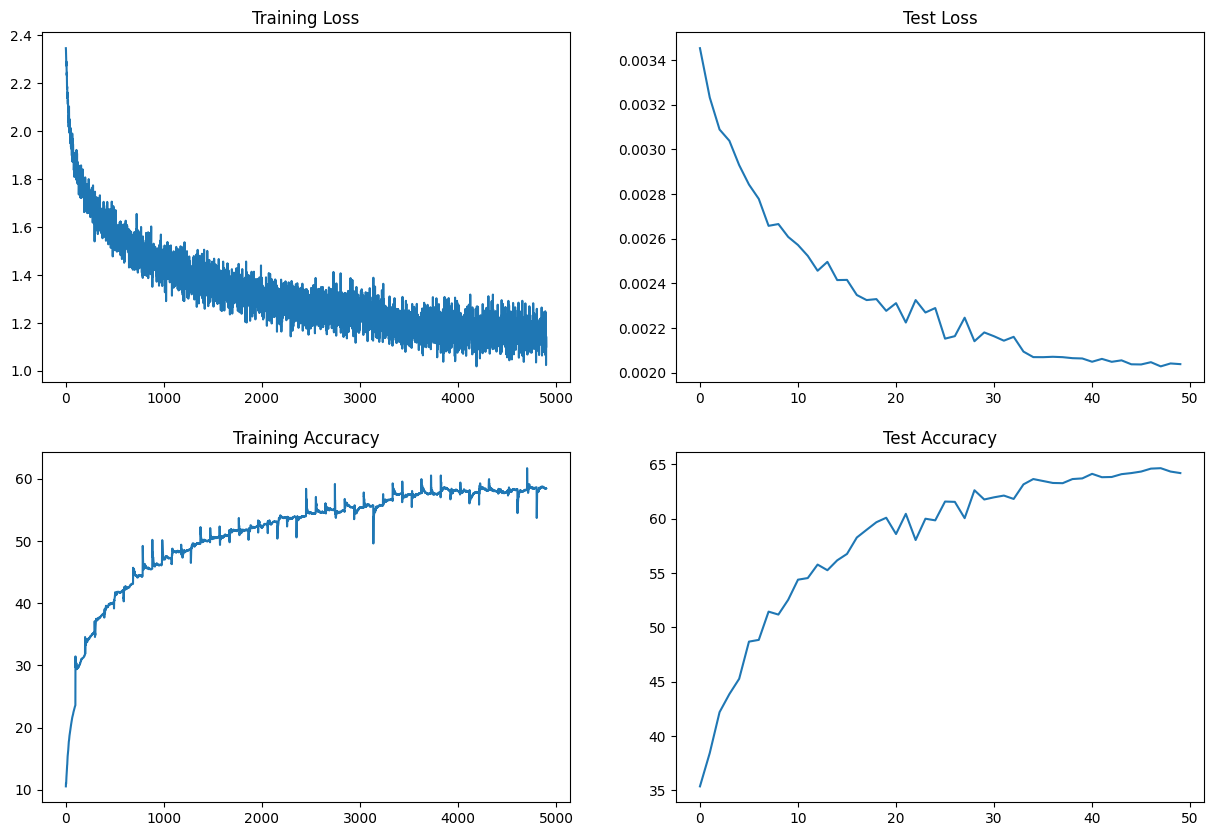

In [24]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Sqeeuze and Expand Architecture

In [7]:
class Net6(nn.Module):
        def __init__(self,sequeeze_channels:list,dp_rate=0.1):
            super(Net6,self).__init__()
            self.dp_rate=dp_rate

            self.C11 =  nn.Sequential(
                        nn.Conv2d(
                            in_channels=sequeeze_channels[0],
                            out_channels=sequeeze_channels[2],
                            kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )

            self.C12 = nn.Sequential(
                        nn.Conv2d(
                            in_channels=sequeeze_channels[2],
                            out_channels=sequeeze_channels[2],
                            kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.C13 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[2],
                                  out_channels=sequeeze_channels[2],
                                  kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.T11 = nn.Sequential(
                nn.Conv2d(in_channels=sequeeze_channels[2],out_channels=sequeeze_channels[1],kernel_size=1,stride=1,bias=False)
            )

            self.C21  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C22 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C23 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T21 = nn.Sequential(nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[3],kernel_size=1,stride=1,bias=False))

            
            self.C31  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C32  =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C33 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T31 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[6],kernel_size=1,stride=1,bias=False)
            )           
            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            
        def forward(self,x):
            x = self.C11(x)
            x = x+self.C12(x)            
            x = self.C13(x)
            x = self.T11(x)

            x = self.C21(x)
            x = x+self.C22(x)
            x = self.C23(x)
            x = self.T21(x)

            x = self.C31(x)
            x = x+self.C32(x)
            x = self.C33(x)
            x = self.T31(x)

            x = self.gap(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [44]:
model6 = Net6(sequeeze_channels=[3,8,16,24,32,40,10],dp_rate=0.15)
summary(model=model6,device=device,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Net6                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           432
│    └─ReLU: 2-2                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-4                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 16, 32, 32]           2,304
│    └─ReLU: 2-6                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-8                    [1, 16, 32, 32]           --
├─Sequential: 1-3                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 16, 16, 16]           2,304
│    └─R

In [45]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model6.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model6, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model6, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model6.state_dict(),f='./bmodels/model6.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 31.27: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.65it/s]


Test set: Average loss: 0.0030, Accuracy: 4206/10000 (42.06%)


EPOCH = 2 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 44.02: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0026, Accuracy: 5113/10000 (51.13%)


EPOCH = 3 | LR = 0.1 | Loss = 1.20 | Batch = 97 | Accuracy = 49.91: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0023, Accuracy: 5684/10000 (56.84%)


EPOCH = 4 | LR = 0.1 | Loss = 1.23 | Batch = 97 | Accuracy = 54.29: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0022, Accuracy: 6087/10000 (60.87%)


EPOCH = 5 | LR = 0.1 | Loss = 1.12 | Batch = 97 | Accuracy = 57.02: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0021, Accuracy: 6233/10000 (62.33%)


EPOCH = 6 | LR = 0.1 | Loss = 1.06 | Batch = 97 | Accuracy = 58.86: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.57it/s]


Test set: Average loss: 0.0020, Accuracy: 6445/10000 (64.45%)


EPOCH = 7 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 60.74: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.57it/s]


Test set: Average loss: 0.0019, Accuracy: 6614/10000 (66.14%)


EPOCH = 8 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 61.47: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.63it/s]


Test set: Average loss: 0.0018, Accuracy: 6736/10000 (67.36%)


EPOCH = 9 | LR = 0.1 | Loss = 1.04 | Batch = 97 | Accuracy = 63.00: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0018, Accuracy: 6814/10000 (68.14%)


EPOCH = 10 | LR = 0.1 | Loss = 1.03 | Batch = 97 | Accuracy = 63.65: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0018, Accuracy: 6882/10000 (68.82%)


EPOCH = 11 | LR = 0.1 | Loss = 1.03 | Batch = 97 | Accuracy = 64.63: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.65it/s]


Test set: Average loss: 0.0017, Accuracy: 6911/10000 (69.11%)


EPOCH = 12 | LR = 0.1 | Loss = 0.95 | Batch = 97 | Accuracy = 65.12: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.61it/s]


Test set: Average loss: 0.0017, Accuracy: 6979/10000 (69.79%)


EPOCH = 13 | LR = 0.1 | Loss = 1.00 | Batch = 97 | Accuracy = 65.99: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0016, Accuracy: 7066/10000 (70.66%)


EPOCH = 14 | LR = 0.1 | Loss = 0.86 | Batch = 97 | Accuracy = 66.63: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0016, Accuracy: 7060/10000 (70.60%)


EPOCH = 15 | LR = 0.1 | Loss = 0.99 | Batch = 97 | Accuracy = 67.00: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.61it/s]


Test set: Average loss: 0.0016, Accuracy: 7167/10000 (71.67%)


EPOCH = 16 | LR = 0.1 | Loss = 0.97 | Batch = 97 | Accuracy = 67.56: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0016, Accuracy: 7204/10000 (72.04%)


EPOCH = 17 | LR = 0.1 | Loss = 0.81 | Batch = 97 | Accuracy = 68.09: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0015, Accuracy: 7244/10000 (72.44%)


EPOCH = 18 | LR = 0.1 | Loss = 0.89 | Batch = 97 | Accuracy = 68.62: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.57it/s]


Test set: Average loss: 0.0015, Accuracy: 7276/10000 (72.76%)


EPOCH = 19 | LR = 0.1 | Loss = 0.94 | Batch = 97 | Accuracy = 69.05: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.58it/s]


Test set: Average loss: 0.0015, Accuracy: 7326/10000 (73.26%)


EPOCH = 20 | LR = 0.1 | Loss = 0.89 | Batch = 97 | Accuracy = 68.87: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.58it/s]


Test set: Average loss: 0.0015, Accuracy: 7371/10000 (73.71%)


EPOCH = 21 | LR = 0.1 | Loss = 0.85 | Batch = 97 | Accuracy = 69.58: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0015, Accuracy: 7394/10000 (73.94%)


EPOCH = 22 | LR = 0.1 | Loss = 0.89 | Batch = 97 | Accuracy = 70.12: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.59it/s]


Test set: Average loss: 0.0015, Accuracy: 7413/10000 (74.13%)


EPOCH = 23 | LR = 0.1 | Loss = 0.71 | Batch = 97 | Accuracy = 70.26: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0015, Accuracy: 7399/10000 (73.99%)


EPOCH = 24 | LR = 0.1 | Loss = 0.75 | Batch = 97 | Accuracy = 70.44: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.66it/s]


Test set: Average loss: 0.0015, Accuracy: 7358/10000 (73.58%)


EPOCH = 25 | LR = 0.1 | Loss = 0.82 | Batch = 97 | Accuracy = 70.59: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.64it/s]


Test set: Average loss: 0.0014, Accuracy: 7432/10000 (74.32%)


EPOCH = 26 | LR = 0.1 | Loss = 0.85 | Batch = 97 | Accuracy = 71.36: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.50it/s]


Test set: Average loss: 0.0014, Accuracy: 7488/10000 (74.88%)


EPOCH = 27 | LR = 0.1 | Loss = 0.80 | Batch = 97 | Accuracy = 71.11: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.55it/s]


Test set: Average loss: 0.0014, Accuracy: 7507/10000 (75.07%)


EPOCH = 28 | LR = 0.1 | Loss = 0.83 | Batch = 97 | Accuracy = 71.45: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0014, Accuracy: 7528/10000 (75.28%)


EPOCH = 29 | LR = 0.1 | Loss = 0.86 | Batch = 97 | Accuracy = 71.89: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0014, Accuracy: 7485/10000 (74.85%)


EPOCH = 30 | LR = 0.1 | Loss = 0.76 | Batch = 97 | Accuracy = 71.93: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.55it/s]


Test set: Average loss: 0.0014, Accuracy: 7621/10000 (76.21%)


EPOCH = 31 | LR = 0.1 | Loss = 0.81 | Batch = 97 | Accuracy = 72.22: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0014, Accuracy: 7600/10000 (76.00%)


EPOCH = 32 | LR = 0.1 | Loss = 0.75 | Batch = 97 | Accuracy = 72.42: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0014, Accuracy: 7536/10000 (75.36%)


EPOCH = 33 | LR = 0.1 | Loss = 0.87 | Batch = 97 | Accuracy = 72.22: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.57it/s]


Test set: Average loss: 0.0014, Accuracy: 7586/10000 (75.86%)


EPOCH = 34 | LR = 0.1 | Loss = 0.87 | Batch = 97 | Accuracy = 72.77: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.55it/s]


Test set: Average loss: 0.0014, Accuracy: 7642/10000 (76.42%)


EPOCH = 35 | LR = 0.010000000000000002 | Loss = 0.78 | Batch = 97 | Accuracy = 73.70: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0013, Accuracy: 7692/10000 (76.92%)


EPOCH = 36 | LR = 0.010000000000000002 | Loss = 0.72 | Batch = 97 | Accuracy = 74.04: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0013, Accuracy: 7712/10000 (77.12%)


EPOCH = 37 | LR = 0.010000000000000002 | Loss = 0.69 | Batch = 97 | Accuracy = 74.68: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0013, Accuracy: 7718/10000 (77.18%)


EPOCH = 38 | LR = 0.010000000000000002 | Loss = 0.67 | Batch = 97 | Accuracy = 74.74: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0013, Accuracy: 7733/10000 (77.33%)


EPOCH = 39 | LR = 0.010000000000000002 | Loss = 0.70 | Batch = 97 | Accuracy = 74.45: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.52it/s]


Test set: Average loss: 0.0013, Accuracy: 7746/10000 (77.46%)


EPOCH = 40 | LR = 0.010000000000000002 | Loss = 0.67 | Batch = 97 | Accuracy = 74.64: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0013, Accuracy: 7722/10000 (77.22%)


EPOCH = 41 | LR = 0.010000000000000002 | Loss = 0.75 | Batch = 97 | Accuracy = 74.63: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0013, Accuracy: 7730/10000 (77.30%)


EPOCH = 42 | LR = 0.010000000000000002 | Loss = 0.70 | Batch = 97 | Accuracy = 75.05: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0013, Accuracy: 7730/10000 (77.30%)


EPOCH = 43 | LR = 0.010000000000000002 | Loss = 0.72 | Batch = 97 | Accuracy = 75.03: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0013, Accuracy: 7752/10000 (77.52%)


EPOCH = 44 | LR = 0.010000000000000002 | Loss = 0.80 | Batch = 97 | Accuracy = 74.81: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0013, Accuracy: 7736/10000 (77.36%)


EPOCH = 45 | LR = 0.010000000000000002 | Loss = 0.68 | Batch = 97 | Accuracy = 75.09: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0013, Accuracy: 7736/10000 (77.36%)


EPOCH = 46 | LR = 0.010000000000000002 | Loss = 0.73 | Batch = 97 | Accuracy = 74.99: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.56it/s]


Test set: Average loss: 0.0013, Accuracy: 7769/10000 (77.69%)


EPOCH = 47 | LR = 0.010000000000000002 | Loss = 0.68 | Batch = 97 | Accuracy = 75.13: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0013, Accuracy: 7751/10000 (77.51%)


EPOCH = 48 | LR = 0.010000000000000002 | Loss = 0.81 | Batch = 97 | Accuracy = 75.12: 100%|██████████████████████████████████████████████| 98/98 [00:26<00:00,  3.66it/s]


Test set: Average loss: 0.0013, Accuracy: 7760/10000 (77.60%)


EPOCH = 49 | LR = 0.010000000000000002 | Loss = 0.70 | Batch = 97 | Accuracy = 75.24: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.63it/s]


Test set: Average loss: 0.0013, Accuracy: 7759/10000 (77.59%)


EPOCH = 50 | LR = 0.010000000000000002 | Loss = 0.72 | Batch = 97 | Accuracy = 75.24: 100%|██████████████████████████████████████████████| 98/98 [00:27<00:00,  3.63it/s]


Test set: Average loss: 0.0013, Accuracy: 7748/10000 (77.48%)


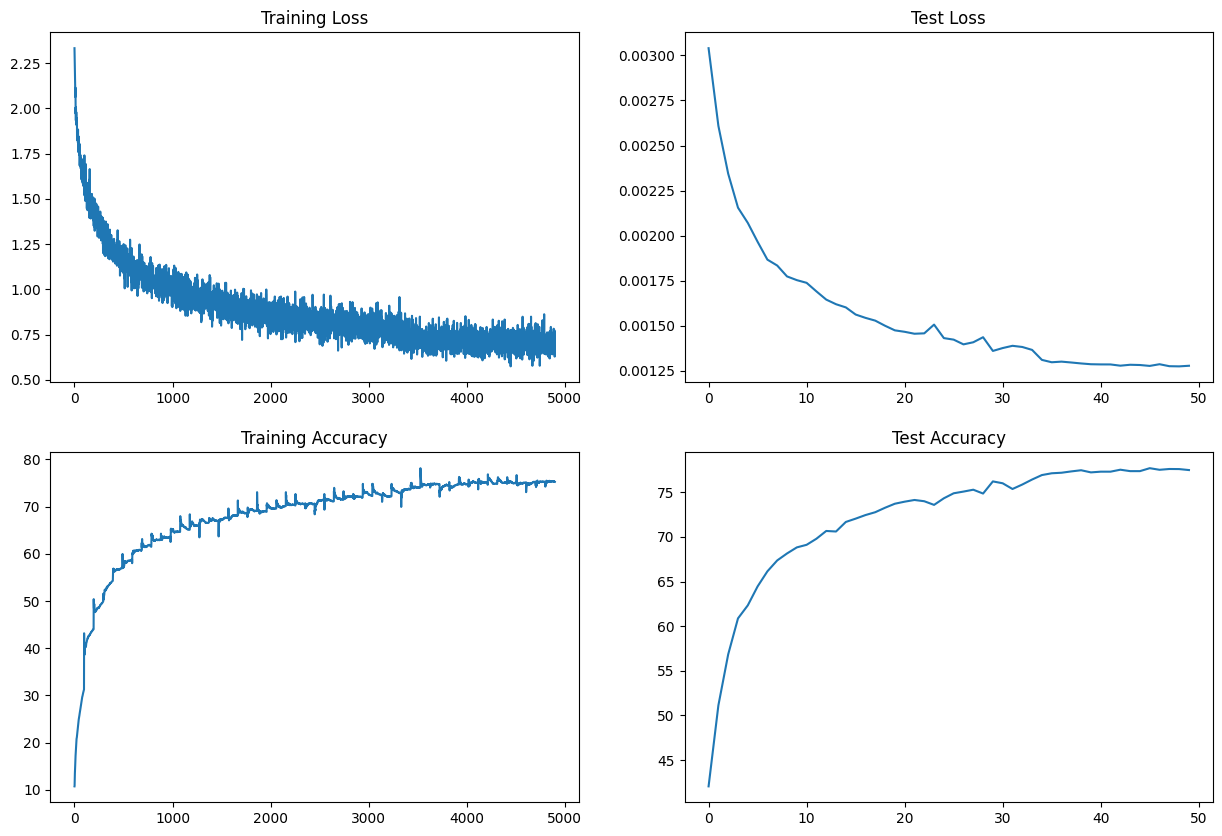

In [46]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [8]:
model7 = Net6(sequeeze_channels=[3,10,20,30,40,50,10],dp_rate=0.15)
summary(model=model7,device=device,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Net6                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 20, 32, 32]           540
│    └─ReLU: 2-2                         [1, 20, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 20, 32, 32]           40
│    └─Dropout2d: 2-4                    [1, 20, 32, 32]           --
├─Sequential: 1-2                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 20, 32, 32]           3,600
│    └─ReLU: 2-6                         [1, 20, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 20, 32, 32]           40
│    └─Dropout2d: 2-8                    [1, 20, 32, 32]           --
├─Sequential: 1-3                        [1, 20, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 20, 16, 16]           3,600
│    └─R

In [9]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model7.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model7, train_loader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model7, test_loader=test_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model7.state_dict(),f='./bmodels/model7.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 33.56: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.03it/s]


Test set: Average loss: 0.0029, Accuracy: 4521/10000 (45.21%)


EPOCH = 2 | LR = 0.1 | Loss = 1.50 | Batch = 97 | Accuracy = 46.00: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.19it/s]


Test set: Average loss: 0.0025, Accuracy: 5415/10000 (54.15%)


EPOCH = 3 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 52.42: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0023, Accuracy: 5845/10000 (58.45%)


EPOCH = 4 | LR = 0.1 | Loss = 1.20 | Batch = 97 | Accuracy = 56.31: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0021, Accuracy: 6281/10000 (62.81%)


EPOCH = 5 | LR = 0.1 | Loss = 1.13 | Batch = 97 | Accuracy = 59.28: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0020, Accuracy: 6465/10000 (64.65%)


EPOCH = 6 | LR = 0.1 | Loss = 1.11 | Batch = 97 | Accuracy = 61.02: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.27it/s]


Test set: Average loss: 0.0019, Accuracy: 6725/10000 (67.25%)


EPOCH = 7 | LR = 0.1 | Loss = 1.02 | Batch = 97 | Accuracy = 63.53: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:07<00:00,  1.44it/s]


Test set: Average loss: 0.0018, Accuracy: 6735/10000 (67.35%)


EPOCH = 8 | LR = 0.1 | Loss = 0.95 | Batch = 97 | Accuracy = 64.70: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0017, Accuracy: 6941/10000 (69.41%)


EPOCH = 9 | LR = 0.1 | Loss = 0.99 | Batch = 97 | Accuracy = 65.98: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0017, Accuracy: 7019/10000 (70.19%)


EPOCH = 10 | LR = 0.1 | Loss = 1.01 | Batch = 97 | Accuracy = 67.06: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.19it/s]


Test set: Average loss: 0.0016, Accuracy: 7128/10000 (71.28%)


EPOCH = 11 | LR = 0.1 | Loss = 0.83 | Batch = 97 | Accuracy = 68.00: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.17it/s]


Test set: Average loss: 0.0016, Accuracy: 7268/10000 (72.68%)


EPOCH = 12 | LR = 0.1 | Loss = 0.92 | Batch = 97 | Accuracy = 69.03: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.14it/s]


Test set: Average loss: 0.0015, Accuracy: 7296/10000 (72.96%)


EPOCH = 13 | LR = 0.1 | Loss = 0.86 | Batch = 97 | Accuracy = 69.85: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.19it/s]


Test set: Average loss: 0.0015, Accuracy: 7348/10000 (73.48%)


EPOCH = 14 | LR = 0.1 | Loss = 0.93 | Batch = 97 | Accuracy = 70.21: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.19it/s]


Test set: Average loss: 0.0015, Accuracy: 7412/10000 (74.12%)


EPOCH = 15 | LR = 0.1 | Loss = 0.86 | Batch = 97 | Accuracy = 71.01: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.17it/s]


Test set: Average loss: 0.0014, Accuracy: 7483/10000 (74.83%)


EPOCH = 16 | LR = 0.1 | Loss = 1.01 | Batch = 97 | Accuracy = 71.66: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.17it/s]


Test set: Average loss: 0.0014, Accuracy: 7462/10000 (74.62%)


EPOCH = 17 | LR = 0.1 | Loss = 0.82 | Batch = 97 | Accuracy = 71.92: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.19it/s]


Test set: Average loss: 0.0014, Accuracy: 7522/10000 (75.22%)


EPOCH = 18 | LR = 0.1 | Loss = 0.81 | Batch = 97 | Accuracy = 72.63: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.00it/s]


Test set: Average loss: 0.0014, Accuracy: 7516/10000 (75.16%)


EPOCH = 19 | LR = 0.1 | Loss = 0.79 | Batch = 97 | Accuracy = 73.01: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0014, Accuracy: 7643/10000 (76.43%)


EPOCH = 20 | LR = 0.1 | Loss = 0.80 | Batch = 97 | Accuracy = 73.56: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0014, Accuracy: 7616/10000 (76.16%)


EPOCH = 21 | LR = 0.1 | Loss = 0.69 | Batch = 97 | Accuracy = 73.55: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.0013, Accuracy: 7665/10000 (76.65%)


EPOCH = 22 | LR = 0.1 | Loss = 0.74 | Batch = 97 | Accuracy = 74.14: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0014, Accuracy: 7619/10000 (76.19%)


EPOCH = 23 | LR = 0.1 | Loss = 0.78 | Batch = 97 | Accuracy = 74.26: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0014, Accuracy: 7659/10000 (76.59%)


EPOCH = 24 | LR = 0.1 | Loss = 0.81 | Batch = 97 | Accuracy = 74.72: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0013, Accuracy: 7710/10000 (77.10%)


EPOCH = 25 | LR = 0.1 | Loss = 0.77 | Batch = 97 | Accuracy = 74.85: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0013, Accuracy: 7684/10000 (76.84%)


EPOCH = 26 | LR = 0.1 | Loss = 0.71 | Batch = 97 | Accuracy = 75.08: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0013, Accuracy: 7733/10000 (77.33%)


EPOCH = 27 | LR = 0.1 | Loss = 0.71 | Batch = 97 | Accuracy = 75.48: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.19it/s]


Test set: Average loss: 0.0013, Accuracy: 7777/10000 (77.77%)


EPOCH = 28 | LR = 0.1 | Loss = 0.66 | Batch = 97 | Accuracy = 75.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0013, Accuracy: 7810/10000 (78.10%)


EPOCH = 29 | LR = 0.1 | Loss = 0.75 | Batch = 97 | Accuracy = 75.55: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0013, Accuracy: 7801/10000 (78.01%)


EPOCH = 30 | LR = 0.1 | Loss = 0.70 | Batch = 97 | Accuracy = 75.97: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0013, Accuracy: 7780/10000 (77.80%)


EPOCH = 31 | LR = 0.1 | Loss = 0.69 | Batch = 97 | Accuracy = 76.15: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0013, Accuracy: 7759/10000 (77.59%)


EPOCH = 32 | LR = 0.1 | Loss = 0.62 | Batch = 97 | Accuracy = 76.67: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0012, Accuracy: 7834/10000 (78.34%)


EPOCH = 33 | LR = 0.1 | Loss = 0.66 | Batch = 97 | Accuracy = 76.29: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0013, Accuracy: 7812/10000 (78.12%)


EPOCH = 34 | LR = 0.1 | Loss = 0.61 | Batch = 97 | Accuracy = 76.50: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.0013, Accuracy: 7802/10000 (78.02%)


EPOCH = 35 | LR = 0.1 | Loss = 0.62 | Batch = 97 | Accuracy = 76.65: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0013, Accuracy: 7787/10000 (77.87%)


EPOCH = 36 | LR = 0.1 | Loss = 0.65 | Batch = 97 | Accuracy = 76.82: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0013, Accuracy: 7851/10000 (78.51%)


EPOCH = 37 | LR = 0.010000000000000002 | Loss = 0.67 | Batch = 97 | Accuracy = 78.12: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0012, Accuracy: 7903/10000 (79.03%)


EPOCH = 38 | LR = 0.010000000000000002 | Loss = 0.55 | Batch = 97 | Accuracy = 78.68: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0012, Accuracy: 7924/10000 (79.24%)


EPOCH = 39 | LR = 0.010000000000000002 | Loss = 0.56 | Batch = 97 | Accuracy = 79.07: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0012, Accuracy: 7941/10000 (79.41%)


EPOCH = 40 | LR = 0.010000000000000002 | Loss = 0.58 | Batch = 97 | Accuracy = 79.02: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0012, Accuracy: 7940/10000 (79.40%)


EPOCH = 41 | LR = 0.010000000000000002 | Loss = 0.55 | Batch = 97 | Accuracy = 79.25: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.0012, Accuracy: 7951/10000 (79.51%)


EPOCH = 42 | LR = 0.010000000000000002 | Loss = 0.56 | Batch = 97 | Accuracy = 79.47: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0012, Accuracy: 7966/10000 (79.66%)


EPOCH = 43 | LR = 0.010000000000000002 | Loss = 0.58 | Batch = 97 | Accuracy = 79.20: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0012, Accuracy: 7962/10000 (79.62%)


EPOCH = 44 | LR = 0.010000000000000002 | Loss = 0.73 | Batch = 97 | Accuracy = 79.39: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0012, Accuracy: 7960/10000 (79.60%)


EPOCH = 45 | LR = 0.010000000000000002 | Loss = 0.58 | Batch = 97 | Accuracy = 79.34: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0012, Accuracy: 7947/10000 (79.47%)


EPOCH = 46 | LR = 0.010000000000000002 | Loss = 0.58 | Batch = 97 | Accuracy = 79.40: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0012, Accuracy: 7965/10000 (79.65%)


EPOCH = 47 | LR = 0.010000000000000002 | Loss = 0.53 | Batch = 97 | Accuracy = 79.65: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0012, Accuracy: 7967/10000 (79.67%)


EPOCH = 48 | LR = 0.010000000000000002 | Loss = 0.61 | Batch = 97 | Accuracy = 79.84: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.21it/s]


Test set: Average loss: 0.0012, Accuracy: 7969/10000 (79.69%)


EPOCH = 49 | LR = 0.010000000000000002 | Loss = 0.61 | Batch = 97 | Accuracy = 79.90: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0012, Accuracy: 7977/10000 (79.77%)


EPOCH = 50 | LR = 0.010000000000000002 | Loss = 0.59 | Batch = 97 | Accuracy = 80.00: 100%|██████████████████████████████████████████████| 98/98 [00:30<00:00,  3.20it/s]


Test set: Average loss: 0.0012, Accuracy: 7970/10000 (79.70%)


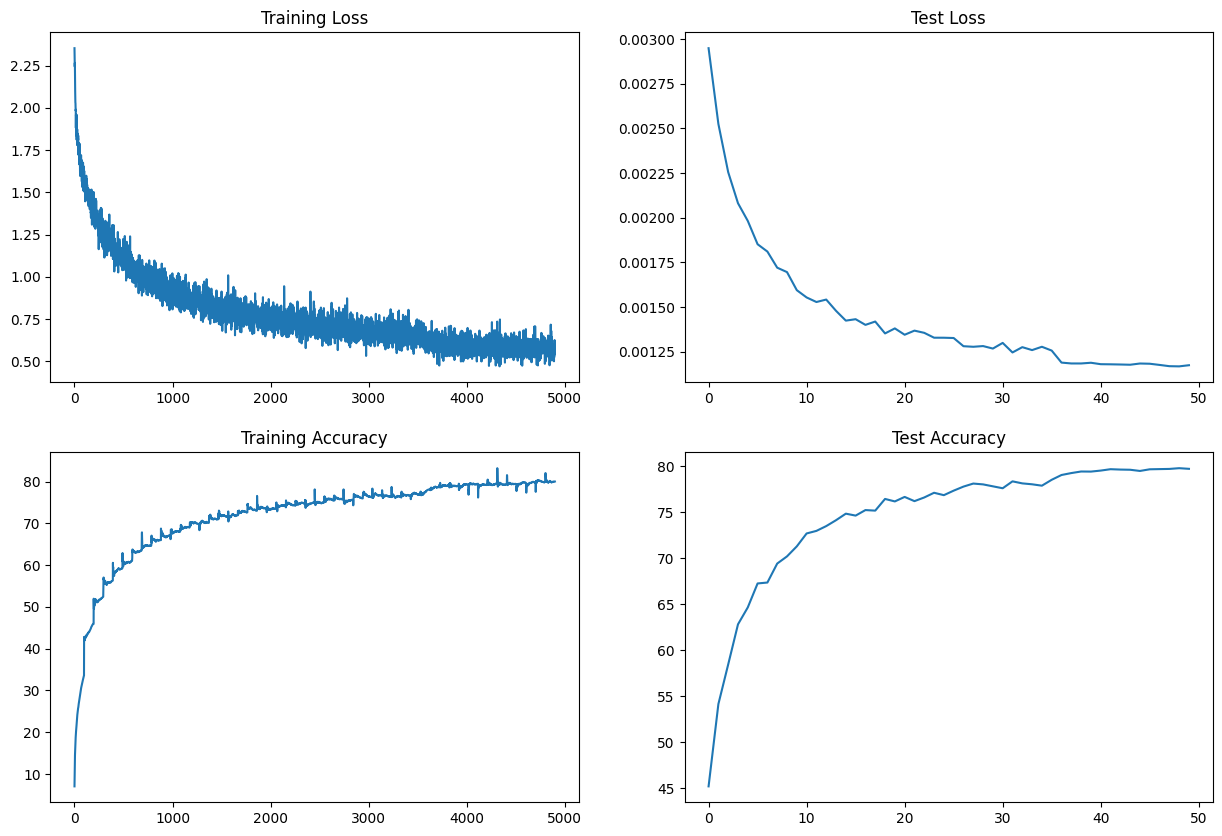

In [10]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model6 with Augmentation

In [11]:
model8 = Net6(sequeeze_channels=[3,8,16,24,32,40,10],dp_rate=0.15)
summary(model=model8,device=device,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Net6                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           432
│    └─ReLU: 2-2                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-4                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 16, 32, 32]           2,304
│    └─ReLU: 2-6                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-8                    [1, 16, 32, 32]           --
├─Sequential: 1-3                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 16, 16, 16]           2,304
│    └─R

In [12]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model8.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model8, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model8, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model8.state_dict(),f='./bmodels/model8.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.84 | Batch = 97 | Accuracy = 26.77: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0032, Accuracy: 4025/10000 (40.25%)


EPOCH = 2 | LR = 0.1 | Loss = 1.71 | Batch = 97 | Accuracy = 35.15: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.25it/s]


Test set: Average loss: 0.0030, Accuracy: 4376/10000 (43.76%)


EPOCH = 3 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 38.33: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


Test set: Average loss: 0.0028, Accuracy: 4856/10000 (48.56%)


EPOCH = 4 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 40.70: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


Test set: Average loss: 0.0027, Accuracy: 5060/10000 (50.60%)


EPOCH = 5 | LR = 0.1 | Loss = 1.60 | Batch = 97 | Accuracy = 42.06: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0026, Accuracy: 5255/10000 (52.55%)


EPOCH = 6 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 43.74: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.28it/s]


Test set: Average loss: 0.0025, Accuracy: 5377/10000 (53.77%)


EPOCH = 7 | LR = 0.1 | Loss = 1.50 | Batch = 97 | Accuracy = 44.60: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


Test set: Average loss: 0.0024, Accuracy: 5591/10000 (55.91%)


EPOCH = 8 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 45.76: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0024, Accuracy: 5639/10000 (56.39%)


EPOCH = 9 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 46.80: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.30it/s]


Test set: Average loss: 0.0023, Accuracy: 5768/10000 (57.68%)


EPOCH = 10 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 47.57: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.33it/s]


Test set: Average loss: 0.0023, Accuracy: 5866/10000 (58.66%)


EPOCH = 11 | LR = 0.1 | Loss = 1.39 | Batch = 97 | Accuracy = 47.99: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.0022, Accuracy: 5941/10000 (59.41%)


EPOCH = 12 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 48.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.23it/s]


Test set: Average loss: 0.0022, Accuracy: 6045/10000 (60.45%)


EPOCH = 13 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 49.20: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.25it/s]


Test set: Average loss: 0.0022, Accuracy: 6106/10000 (61.06%)


EPOCH = 14 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 49.77: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0021, Accuracy: 6221/10000 (62.21%)


EPOCH = 15 | LR = 0.1 | Loss = 1.43 | Batch = 97 | Accuracy = 50.43: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.0021, Accuracy: 6205/10000 (62.05%)


EPOCH = 16 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 50.63: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.27it/s]


Test set: Average loss: 0.0021, Accuracy: 6259/10000 (62.59%)


EPOCH = 17 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 51.29: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.25it/s]


Test set: Average loss: 0.0020, Accuracy: 6347/10000 (63.47%)


EPOCH = 18 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 51.57: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.0020, Accuracy: 6340/10000 (63.40%)


EPOCH = 19 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 52.02: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.22it/s]


Test set: Average loss: 0.0020, Accuracy: 6388/10000 (63.88%)


EPOCH = 20 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 52.08: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0020, Accuracy: 6535/10000 (65.35%)


EPOCH = 21 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 52.88: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


Test set: Average loss: 0.0019, Accuracy: 6545/10000 (65.45%)


EPOCH = 22 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 52.62: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.27it/s]


Test set: Average loss: 0.0020, Accuracy: 6492/10000 (64.92%)


EPOCH = 23 | LR = 0.1 | Loss = 1.33 | Batch = 97 | Accuracy = 53.17: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0019, Accuracy: 6492/10000 (64.92%)


EPOCH = 24 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 53.31: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.25it/s]


Test set: Average loss: 0.0019, Accuracy: 6572/10000 (65.72%)


EPOCH = 25 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 53.58: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.24it/s]


Test set: Average loss: 0.0019, Accuracy: 6604/10000 (66.04%)


EPOCH = 26 | LR = 0.1 | Loss = 1.24 | Batch = 97 | Accuracy = 53.90: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0019, Accuracy: 6753/10000 (67.53%)


EPOCH = 27 | LR = 0.1 | Loss = 1.20 | Batch = 97 | Accuracy = 53.97: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.26it/s]


Test set: Average loss: 0.0019, Accuracy: 6690/10000 (66.90%)


EPOCH = 28 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 54.46: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.33it/s]


Test set: Average loss: 0.0018, Accuracy: 6740/10000 (67.40%)


EPOCH = 29 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 54.27: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.16it/s]


Test set: Average loss: 0.0018, Accuracy: 6728/10000 (67.28%)


EPOCH = 30 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 54.63: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.29it/s]


Test set: Average loss: 0.0018, Accuracy: 6822/10000 (68.22%)


EPOCH = 31 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 54.77: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.68it/s]


Test set: Average loss: 0.0018, Accuracy: 6737/10000 (67.37%)


EPOCH = 32 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 54.86: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0018, Accuracy: 6838/10000 (68.38%)


EPOCH = 33 | LR = 0.1 | Loss = 1.24 | Batch = 97 | Accuracy = 55.45: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.70it/s]


Test set: Average loss: 0.0018, Accuracy: 6830/10000 (68.30%)


EPOCH = 34 | LR = 0.1 | Loss = 1.28 | Batch = 97 | Accuracy = 55.42: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0018, Accuracy: 6872/10000 (68.72%)


EPOCH = 35 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 55.40: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.61it/s]


Test set: Average loss: 0.0017, Accuracy: 6941/10000 (69.41%)


EPOCH = 36 | LR = 0.1 | Loss = 1.21 | Batch = 97 | Accuracy = 55.70: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.61it/s]


Test set: Average loss: 0.0017, Accuracy: 6907/10000 (69.07%)


EPOCH = 37 | LR = 0.1 | Loss = 1.25 | Batch = 97 | Accuracy = 55.81: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.54it/s]


Test set: Average loss: 0.0018, Accuracy: 6868/10000 (68.68%)


EPOCH = 38 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 55.99: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.66it/s]


Test set: Average loss: 0.0017, Accuracy: 6943/10000 (69.43%)


EPOCH = 39 | LR = 0.1 | Loss = 1.18 | Batch = 97 | Accuracy = 56.40: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.66it/s]


Test set: Average loss: 0.0017, Accuracy: 7018/10000 (70.18%)


EPOCH = 40 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 56.33: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.63it/s]


Test set: Average loss: 0.0018, Accuracy: 6897/10000 (68.97%)


EPOCH = 41 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 56.36: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:29<00:00,  3.34it/s]


Test set: Average loss: 0.0017, Accuracy: 6986/10000 (69.86%)


EPOCH = 42 | LR = 0.1 | Loss = 1.18 | Batch = 97 | Accuracy = 56.59: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.52it/s]


Test set: Average loss: 0.0017, Accuracy: 6905/10000 (69.05%)


EPOCH = 43 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 56.49: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0017, Accuracy: 6994/10000 (69.94%)


EPOCH = 44 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 56.82: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0017, Accuracy: 7059/10000 (70.59%)


EPOCH = 45 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 56.96: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.63it/s]


Test set: Average loss: 0.0017, Accuracy: 7050/10000 (70.50%)


EPOCH = 46 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 57.28: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.62it/s]


Test set: Average loss: 0.0017, Accuracy: 7075/10000 (70.75%)


EPOCH = 47 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 57.35: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.60it/s]


Test set: Average loss: 0.0017, Accuracy: 7087/10000 (70.87%)


EPOCH = 48 | LR = 0.1 | Loss = 1.19 | Batch = 97 | Accuracy = 57.48: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:28<00:00,  3.42it/s]


Test set: Average loss: 0.0017, Accuracy: 7146/10000 (71.46%)


EPOCH = 49 | LR = 0.1 | Loss = 1.25 | Batch = 97 | Accuracy = 57.83: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:27<00:00,  3.57it/s]


Test set: Average loss: 0.0016, Accuracy: 7142/10000 (71.42%)


EPOCH = 50 | LR = 0.1 | Loss = 1.20 | Batch = 97 | Accuracy = 57.58: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:26<00:00,  3.67it/s]


Test set: Average loss: 0.0017, Accuracy: 6982/10000 (69.82%)


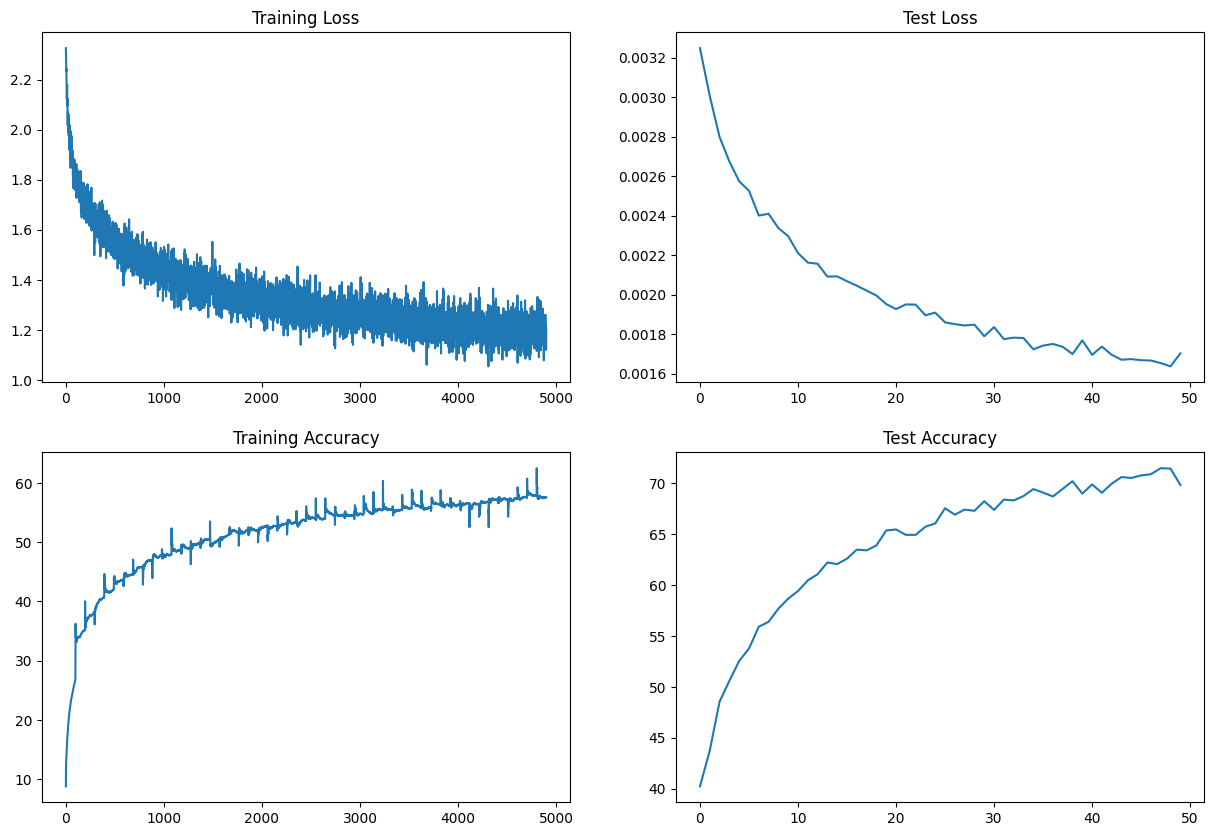

In [13]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model6 replaced with DepthWise Seperable Conv

In [15]:
class Net9(nn.Module):
        def __init__(self,sequeeze_channels:list,dp_rate=0.1):
            super(Net9,self).__init__()
            self.dp_rate=dp_rate

            self.C11 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeaze_channels[0] ,out_channels=sequeeze_channels[0],groups=sequeeze_channels[0], kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[0], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(
                        #     in_channels=sequeeze_channels[0],
                        #     out_channels=sequeeze_channels[2],
                        #     kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )

            self.C12 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[2] ,out_channels=sequeeze_channels[2],groups=sequeeze_channels[2], kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[2], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        
                        # nn.Conv2d(
                        #     in_channels=sequeeze_channels[2],
                        #     out_channels=sequeeze_channels[2],
                        #     kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.C13 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[2] ,out_channels=sequeeze_channels[2],groups=sequeeze_channels[2], kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[2], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[2],
                        #           out_channels=sequeeze_channels[2],
                        #           kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.T11 = nn.Sequential(
                nn.Conv2d(in_channels=sequeeze_channels[2],out_channels=sequeeze_channels[1],kernel_size=1,stride=1,bias=False)
            )


            self.C21  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[1],groups=sequeeze_channels[1],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C22 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C23 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T21 = nn.Sequential(nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[3],kernel_size=1,stride=1,bias=False))

            
            self.C31  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[3],groups=sequeeze_channels[3],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C32  =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C33 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T31 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[6],kernel_size=1,stride=1,bias=False)
            )           
            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            
        def forward(self,x):
            x = self.C11(x)
            x = x+self.C12(x)            
            x = self.C13(x)
            x = self.T11(x)
            
            x = self.C21(x)
            x = x+self.C22(x)
            x = self.C23(x)
            x = self.T21(x)

            x = self.C31(x)
            x = x+self.C32(x)
            x = self.C33(x)
            x = self.T31(x)

            x = self.gap(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [16]:
model9 = Net9(sequeeze_channels=[3,8,16,24,32,40,10],dp_rate=0.15)
summary(model=model9,device=device,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
Net9                                     [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 3, 32, 32]            27
│    └─Conv2d: 2-2                       [1, 16, 32, 32]           48
│    └─ReLU: 2-3                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-4                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-5                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-6                       [1, 16, 32, 32]           144
│    └─Conv2d: 2-7                       [1, 16, 32, 32]           256
│    └─ReLU: 2-8                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-9                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-10                   [1, 16, 32, 32]           --
├─Sequential:

In [17]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model9.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model9, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model9, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model9.state_dict(),f='./bmodels/model9.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.95 | Batch = 97 | Accuracy = 21.48: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.63it/s]


Test set: Average loss: 0.0036, Accuracy: 2873/10000 (28.73%)


EPOCH = 2 | LR = 0.1 | Loss = 1.85 | Batch = 97 | Accuracy = 28.77: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.61it/s]


Test set: Average loss: 0.0033, Accuracy: 3644/10000 (36.44%)


EPOCH = 3 | LR = 0.1 | Loss = 1.79 | Batch = 97 | Accuracy = 32.03: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.61it/s]


Test set: Average loss: 0.0033, Accuracy: 3842/10000 (38.42%)


EPOCH = 4 | LR = 0.1 | Loss = 1.77 | Batch = 97 | Accuracy = 34.34: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.63it/s]


Test set: Average loss: 0.0031, Accuracy: 4282/10000 (42.82%)


EPOCH = 5 | LR = 0.1 | Loss = 1.65 | Batch = 97 | Accuracy = 35.71: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.60it/s]


Test set: Average loss: 0.0031, Accuracy: 4353/10000 (43.53%)


EPOCH = 6 | LR = 0.1 | Loss = 1.62 | Batch = 97 | Accuracy = 36.64: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.60it/s]


Test set: Average loss: 0.0029, Accuracy: 4620/10000 (46.20%)


EPOCH = 7 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 38.52: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.59it/s]


Test set: Average loss: 0.0029, Accuracy: 4677/10000 (46.77%)


EPOCH = 8 | LR = 0.1 | Loss = 1.66 | Batch = 97 | Accuracy = 39.49: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0028, Accuracy: 4820/10000 (48.20%)


EPOCH = 9 | LR = 0.1 | Loss = 1.62 | Batch = 97 | Accuracy = 40.20: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:38<00:00,  2.56it/s]


Test set: Average loss: 0.0028, Accuracy: 5014/10000 (50.14%)


EPOCH = 10 | LR = 0.1 | Loss = 1.62 | Batch = 97 | Accuracy = 40.90: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0027, Accuracy: 4997/10000 (49.97%)


EPOCH = 11 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 41.40: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:38<00:00,  2.52it/s]


Test set: Average loss: 0.0027, Accuracy: 5088/10000 (50.88%)


EPOCH = 12 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 42.20: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.61it/s]


Test set: Average loss: 0.0026, Accuracy: 5317/10000 (53.17%)


EPOCH = 13 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 43.21: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:37<00:00,  2.60it/s]


Test set: Average loss: 0.0027, Accuracy: 5206/10000 (52.06%)


EPOCH = 14 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 43.20: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0026, Accuracy: 5280/10000 (52.80%)


EPOCH = 15 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 43.51: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:46<00:00,  2.10it/s]


Test set: Average loss: 0.0025, Accuracy: 5385/10000 (53.85%)


EPOCH = 16 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 44.06: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:00<00:00,  1.63it/s]


Test set: Average loss: 0.0025, Accuracy: 5394/10000 (53.94%)


EPOCH = 17 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 44.37: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:01<00:00,  1.61it/s]


Test set: Average loss: 0.0024, Accuracy: 5615/10000 (56.15%)


EPOCH = 18 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 44.75: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:48<00:00,  2.00it/s]


Test set: Average loss: 0.0025, Accuracy: 5517/10000 (55.17%)


EPOCH = 19 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 45.06: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0025, Accuracy: 5547/10000 (55.47%)


EPOCH = 20 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 45.44: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0025, Accuracy: 5590/10000 (55.90%)


EPOCH = 21 | LR = 0.1 | Loss = 1.52 | Batch = 97 | Accuracy = 45.31: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.41it/s]


Test set: Average loss: 0.0024, Accuracy: 5735/10000 (57.35%)


EPOCH = 22 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 45.56: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:40<00:00,  2.43it/s]


Test set: Average loss: 0.0024, Accuracy: 5708/10000 (57.08%)


EPOCH = 23 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 45.87: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:51<00:00,  1.92it/s]


Test set: Average loss: 0.0024, Accuracy: 5808/10000 (58.08%)


EPOCH = 24 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 45.96: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:01<00:00,  1.60it/s]


Test set: Average loss: 0.0024, Accuracy: 5642/10000 (56.42%)


EPOCH = 25 | LR = 0.1 | Loss = 1.52 | Batch = 97 | Accuracy = 46.33: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:01<00:00,  1.59it/s]


Test set: Average loss: 0.0024, Accuracy: 5689/10000 (56.89%)


EPOCH = 26 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 46.17: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 0.0023, Accuracy: 5893/10000 (58.93%)


EPOCH = 27 | LR = 0.1 | Loss = 1.39 | Batch = 97 | Accuracy = 46.40: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:39<00:00,  2.47it/s]


Test set: Average loss: 0.0024, Accuracy: 5668/10000 (56.68%)


EPOCH = 28 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 46.70: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:41<00:00,  2.33it/s]


Test set: Average loss: 0.0023, Accuracy: 5816/10000 (58.16%)


EPOCH = 29 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 47.31: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0024, Accuracy: 5828/10000 (58.28%)


EPOCH = 30 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 47.25: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:41<00:00,  2.37it/s]


Test set: Average loss: 0.0023, Accuracy: 5874/10000 (58.74%)


EPOCH = 31 | LR = 0.010000000000000002 | Loss = 1.45 | Batch = 97 | Accuracy = 47.97: 100%|██████████████████████████████████████████████| 98/98 [00:45<00:00,  2.16it/s]


Test set: Average loss: 0.0022, Accuracy: 5973/10000 (59.73%)


EPOCH = 32 | LR = 0.010000000000000002 | Loss = 1.49 | Batch = 97 | Accuracy = 48.19: 100%|██████████████████████████████████████████████| 98/98 [00:56<00:00,  1.75it/s]


Test set: Average loss: 0.0022, Accuracy: 5980/10000 (59.80%)


EPOCH = 33 | LR = 0.010000000000000002 | Loss = 1.42 | Batch = 97 | Accuracy = 48.69: 100%|██████████████████████████████████████████████| 98/98 [01:01<00:00,  1.59it/s]


Test set: Average loss: 0.0022, Accuracy: 6001/10000 (60.01%)


EPOCH = 34 | LR = 0.010000000000000002 | Loss = 1.43 | Batch = 97 | Accuracy = 48.51: 100%|██████████████████████████████████████████████| 98/98 [00:51<00:00,  1.90it/s]


Test set: Average loss: 0.0022, Accuracy: 5985/10000 (59.85%)


EPOCH = 35 | LR = 0.010000000000000002 | Loss = 1.32 | Batch = 97 | Accuracy = 48.79: 100%|██████████████████████████████████████████████| 98/98 [00:39<00:00,  2.49it/s]


Test set: Average loss: 0.0022, Accuracy: 6016/10000 (60.16%)


EPOCH = 36 | LR = 0.010000000000000002 | Loss = 1.31 | Batch = 97 | Accuracy = 48.69: 100%|██████████████████████████████████████████████| 98/98 [00:39<00:00,  2.50it/s]


Test set: Average loss: 0.0022, Accuracy: 5993/10000 (59.93%)


EPOCH = 37 | LR = 0.010000000000000002 | Loss = 1.35 | Batch = 97 | Accuracy = 48.97: 100%|██████████████████████████████████████████████| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0022, Accuracy: 6048/10000 (60.48%)


EPOCH = 38 | LR = 0.010000000000000002 | Loss = 1.44 | Batch = 97 | Accuracy = 48.62: 100%|██████████████████████████████████████████████| 98/98 [00:37<00:00,  2.62it/s]


Test set: Average loss: 0.0022, Accuracy: 6014/10000 (60.14%)


EPOCH = 39 | LR = 0.010000000000000002 | Loss = 1.33 | Batch = 97 | Accuracy = 48.69: 100%|██████████████████████████████████████████████| 98/98 [00:37<00:00,  2.62it/s]


Test set: Average loss: 0.0022, Accuracy: 6013/10000 (60.13%)


EPOCH = 40 | LR = 0.010000000000000002 | Loss = 1.45 | Batch = 97 | Accuracy = 48.59: 100%|██████████████████████████████████████████████| 98/98 [00:37<00:00,  2.63it/s]


Test set: Average loss: 0.0022, Accuracy: 6012/10000 (60.12%)


EPOCH = 41 | LR = 0.010000000000000002 | Loss = 1.39 | Batch = 97 | Accuracy = 48.70: 100%|██████████████████████████████████████████████| 98/98 [00:37<00:00,  2.63it/s]


Test set: Average loss: 0.0022, Accuracy: 6040/10000 (60.40%)


EPOCH = 42 | LR = 0.0010000000000000002 | Loss = 1.49 | Batch = 97 | Accuracy = 49.15: 100%|█████████████████████████████████████████████| 98/98 [00:37<00:00,  2.61it/s]


Test set: Average loss: 0.0022, Accuracy: 6064/10000 (60.64%)


EPOCH = 43 | LR = 0.0010000000000000002 | Loss = 1.41 | Batch = 97 | Accuracy = 49.17: 100%|█████████████████████████████████████████████| 98/98 [00:48<00:00,  2.04it/s]


Test set: Average loss: 0.0022, Accuracy: 6058/10000 (60.58%)


EPOCH = 44 | LR = 0.0010000000000000002 | Loss = 1.43 | Batch = 97 | Accuracy = 48.95: 100%|█████████████████████████████████████████████| 98/98 [00:37<00:00,  2.62it/s]


Test set: Average loss: 0.0022, Accuracy: 6060/10000 (60.60%)


EPOCH = 45 | LR = 0.0010000000000000002 | Loss = 1.39 | Batch = 97 | Accuracy = 49.06: 100%|█████████████████████████████████████████████| 98/98 [00:37<00:00,  2.63it/s]


Test set: Average loss: 0.0022, Accuracy: 6051/10000 (60.51%)


EPOCH = 46 | LR = 0.0010000000000000002 | Loss = 1.38 | Batch = 97 | Accuracy = 49.29: 100%|█████████████████████████████████████████████| 98/98 [00:38<00:00,  2.56it/s]


Test set: Average loss: 0.0022, Accuracy: 6047/10000 (60.47%)


EPOCH = 47 | LR = 0.00010000000000000003 | Loss = 1.39 | Batch = 97 | Accuracy = 49.20: 100%|████████████████████████████████████████████| 98/98 [00:37<00:00,  2.60it/s]


Test set: Average loss: 0.0022, Accuracy: 6027/10000 (60.27%)


EPOCH = 48 | LR = 0.00010000000000000003 | Loss = 1.35 | Batch = 97 | Accuracy = 48.99: 100%|████████████████████████████████████████████| 98/98 [00:37<00:00,  2.60it/s]


Test set: Average loss: 0.0022, Accuracy: 6042/10000 (60.42%)


EPOCH = 49 | LR = 0.00010000000000000003 | Loss = 1.31 | Batch = 97 | Accuracy = 48.99: 100%|████████████████████████████████████████████| 98/98 [00:37<00:00,  2.61it/s]


Test set: Average loss: 0.0022, Accuracy: 6018/10000 (60.18%)


EPOCH = 50 | LR = 0.00010000000000000003 | Loss = 1.31 | Batch = 97 | Accuracy = 49.09: 100%|████████████████████████████████████████████| 98/98 [00:37<00:00,  2.60it/s]


Test set: Average loss: 0.0022, Accuracy: 6028/10000 (60.28%)


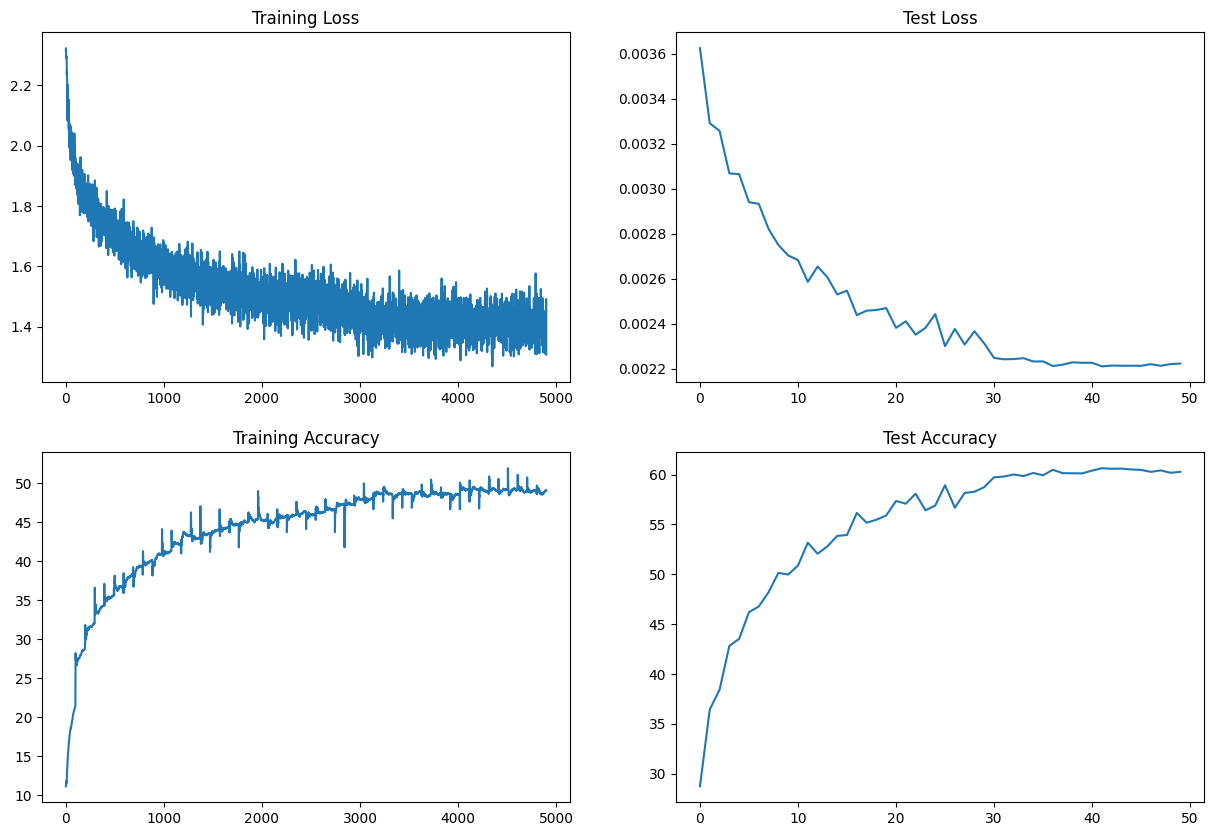

In [18]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# removing top depthwise seperable conv

In [20]:
class Net91(nn.Module):
        def __init__(self,sequeeze_channels:list,dp_rate=0.1):
            super(Net91,self).__init__()
            self.dp_rate=dp_rate

            self.C11 =  nn.Sequential(
                        # nn.Conv2d(in_channels=sequeeaze_channels[0] ,out_channels=sequeeze_channels[0],groups=sequeeze_channels[0], kernel_size=3,bias=False,padding=1,stride=1),
                        # nn.Conv2d(in_channels=sequeeze_channels[0], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        nn.Conv2d(
                            in_channels=sequeeze_channels[0],
                            out_channels=sequeeze_channels[2],
                            kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )

            self.C12 = nn.Sequential(
                        # nn.Conv2d(in_channels=sequeeze_channels[2] ,out_channels=sequeeze_channels[2],groups=sequeeze_channels[2], kernel_size=3,bias=False,padding=1,stride=1),
                        # nn.Conv2d(in_channels=sequeeze_channels[2], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        
                        nn.Conv2d(
                            in_channels=sequeeze_channels[2],
                            out_channels=sequeeze_channels[2],
                            kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.C13 = nn.Sequential(
                        # nn.Conv2d(in_channels=sequeeze_channels[2] ,out_channels=sequeeze_channels[2],groups=sequeeze_channels[2], kernel_size=3,bias=False,padding=1,stride=1),
                        # nn.Conv2d(in_channels=sequeeze_channels[2], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        nn.Conv2d(in_channels=sequeeze_channels[2],
                                  out_channels=sequeeze_channels[2],
                                  kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.T11 = nn.Sequential(
                nn.Conv2d(in_channels=sequeeze_channels[2],out_channels=sequeeze_channels[1],kernel_size=1,stride=1,bias=False)
            )


            self.C21  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[1],groups=sequeeze_channels[1],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C22 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C23 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T21 = nn.Sequential(nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[3],kernel_size=1,stride=1,bias=False))

            
            self.C31  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[3],groups=sequeeze_channels[3],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C32  =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C33 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T31 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[6],kernel_size=1,stride=1,bias=False)
            )           
            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            
        def forward(self,x):
            x = self.C11(x)
            x = x+self.C12(x)            
            x = self.C13(x)
            x = self.T11(x)
            
            x = self.C21(x)
            x = x+self.C22(x)
            x = self.C23(x)
            x = self.T21(x)

            x = self.C31(x)
            x = x+self.C32(x)
            x = self.C33(x)
            x = self.T31(x)

            x = self.gap(x)
            return F.log_softmax(x.view(-1,10), dim=1)

In [22]:
model91 = Net91(sequeeze_channels=[3,8,16,24,32,40,10],dp_rate=0.15)
summary(model=model91,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net91                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 16, 32, 32]           432
│    └─ReLU: 2-2                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-4                    [1, 16, 32, 32]           --
├─Sequential: 1-2                        [1, 16, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 16, 32, 32]           2,304
│    └─ReLU: 2-6                         [1, 16, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 16, 32, 32]           32
│    └─Dropout2d: 2-8                    [1, 16, 32, 32]           --
├─Sequential: 1-3                        [1, 16, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 16, 16, 16]           2,304
│    └─R

In [23]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model91.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model91, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model91, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model91.state_dict(),f='./bmodels/model91.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.1 | Loss = 1.99 | Batch = 97 | Accuracy = 22.76: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.00it/s]


Test set: Average loss: 0.0036, Accuracy: 3242/10000 (32.42%)


EPOCH = 2 | LR = 0.1 | Loss = 1.72 | Batch = 97 | Accuracy = 30.47: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.13it/s]


Test set: Average loss: 0.0033, Accuracy: 3888/10000 (38.88%)


EPOCH = 3 | LR = 0.1 | Loss = 1.69 | Batch = 97 | Accuracy = 34.11: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.13it/s]


Test set: Average loss: 0.0031, Accuracy: 4332/10000 (43.32%)


EPOCH = 4 | LR = 0.1 | Loss = 1.72 | Batch = 97 | Accuracy = 35.95: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.13it/s]


Test set: Average loss: 0.0030, Accuracy: 4406/10000 (44.06%)


EPOCH = 5 | LR = 0.1 | Loss = 1.75 | Batch = 97 | Accuracy = 37.41: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:30<00:00,  3.18it/s]


Test set: Average loss: 0.0029, Accuracy: 4612/10000 (46.12%)


EPOCH = 6 | LR = 0.1 | Loss = 1.60 | Batch = 97 | Accuracy = 38.85: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0028, Accuracy: 4913/10000 (49.13%)


EPOCH = 7 | LR = 0.1 | Loss = 1.64 | Batch = 97 | Accuracy = 39.92: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0028, Accuracy: 4799/10000 (47.99%)


EPOCH = 8 | LR = 0.1 | Loss = 1.67 | Batch = 97 | Accuracy = 40.68: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0027, Accuracy: 5018/10000 (50.18%)


EPOCH = 9 | LR = 0.1 | Loss = 1.61 | Batch = 97 | Accuracy = 41.35: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0027, Accuracy: 5098/10000 (50.98%)


EPOCH = 10 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 42.66: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0026, Accuracy: 5204/10000 (52.04%)


EPOCH = 11 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 43.00: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0026, Accuracy: 5319/10000 (53.19%)


EPOCH = 12 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 43.51: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0026, Accuracy: 5278/10000 (52.78%)


EPOCH = 13 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 43.85: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0025, Accuracy: 5481/10000 (54.81%)


EPOCH = 14 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 44.27: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0024, Accuracy: 5496/10000 (54.96%)


EPOCH = 15 | LR = 0.1 | Loss = 1.58 | Batch = 97 | Accuracy = 44.83: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0025, Accuracy: 5488/10000 (54.88%)


EPOCH = 16 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 44.81: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0025, Accuracy: 5417/10000 (54.17%)


EPOCH = 17 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 45.61: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0024, Accuracy: 5551/10000 (55.51%)


EPOCH = 18 | LR = 0.1 | Loss = 1.55 | Batch = 97 | Accuracy = 45.50: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0024, Accuracy: 5669/10000 (56.69%)


EPOCH = 19 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 46.02: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0024, Accuracy: 5612/10000 (56.12%)


EPOCH = 20 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 46.24: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0023, Accuracy: 5730/10000 (57.30%)


EPOCH = 21 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 46.33: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0023, Accuracy: 5670/10000 (56.70%)


EPOCH = 22 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 46.28: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0023, Accuracy: 5707/10000 (57.07%)


EPOCH = 23 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 46.50: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0023, Accuracy: 5810/10000 (58.10%)


EPOCH = 24 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 47.33: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0023, Accuracy: 5794/10000 (57.94%)


EPOCH = 25 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 47.33: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0023, Accuracy: 5786/10000 (57.86%)


EPOCH = 26 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 47.61: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0023, Accuracy: 5661/10000 (56.61%)


EPOCH = 27 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 47.72: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0023, Accuracy: 5906/10000 (59.06%)


EPOCH = 28 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 47.93: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0022, Accuracy: 5982/10000 (59.82%)


EPOCH = 29 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 47.78: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0023, Accuracy: 5793/10000 (57.93%)


EPOCH = 30 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 48.09: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0023, Accuracy: 5924/10000 (59.24%)


EPOCH = 31 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 48.17: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0022, Accuracy: 6051/10000 (60.51%)


EPOCH = 32 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 47.99: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.14it/s]


Test set: Average loss: 0.0023, Accuracy: 5844/10000 (58.44%)


EPOCH = 33 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 48.61: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0022, Accuracy: 6001/10000 (60.01%)


EPOCH = 34 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 48.70: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.13it/s]


Test set: Average loss: 0.0022, Accuracy: 5984/10000 (59.84%)


EPOCH = 35 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 48.64: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.07it/s]


Test set: Average loss: 0.0022, Accuracy: 5972/10000 (59.72%)


EPOCH = 36 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 49.04: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0022, Accuracy: 5971/10000 (59.71%)


EPOCH = 37 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 48.88: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0022, Accuracy: 6082/10000 (60.82%)


EPOCH = 38 | LR = 0.010000000000000002 | Loss = 1.44 | Batch = 97 | Accuracy = 49.97: 100%|██████████████████████████████████████████████| 98/98 [00:32<00:00,  3.06it/s]


Test set: Average loss: 0.0021, Accuracy: 6181/10000 (61.81%)


EPOCH = 39 | LR = 0.010000000000000002 | Loss = 1.30 | Batch = 97 | Accuracy = 50.47: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6189/10000 (61.89%)


EPOCH = 40 | LR = 0.010000000000000002 | Loss = 1.43 | Batch = 97 | Accuracy = 50.62: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0021, Accuracy: 6171/10000 (61.71%)


EPOCH = 41 | LR = 0.010000000000000002 | Loss = 1.40 | Batch = 97 | Accuracy = 50.77: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6185/10000 (61.85%)


EPOCH = 42 | LR = 0.010000000000000002 | Loss = 1.42 | Batch = 97 | Accuracy = 50.92: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6188/10000 (61.88%)


EPOCH = 43 | LR = 0.010000000000000002 | Loss = 1.35 | Batch = 97 | Accuracy = 50.43: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6201/10000 (62.01%)


EPOCH = 44 | LR = 0.010000000000000002 | Loss = 1.30 | Batch = 97 | Accuracy = 50.55: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0021, Accuracy: 6202/10000 (62.02%)


EPOCH = 45 | LR = 0.010000000000000002 | Loss = 1.36 | Batch = 97 | Accuracy = 50.67: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6170/10000 (61.70%)


EPOCH = 46 | LR = 0.010000000000000002 | Loss = 1.31 | Batch = 97 | Accuracy = 50.42: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0021, Accuracy: 6227/10000 (62.27%)


EPOCH = 47 | LR = 0.010000000000000002 | Loss = 1.29 | Batch = 97 | Accuracy = 50.97: 100%|██████████████████████████████████████████████| 98/98 [00:32<00:00,  3.03it/s]


Test set: Average loss: 0.0021, Accuracy: 6238/10000 (62.38%)


EPOCH = 48 | LR = 0.010000000000000002 | Loss = 1.48 | Batch = 97 | Accuracy = 50.77: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0021, Accuracy: 6226/10000 (62.26%)


EPOCH = 49 | LR = 0.010000000000000002 | Loss = 1.38 | Batch = 97 | Accuracy = 50.79: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0021, Accuracy: 6219/10000 (62.19%)


EPOCH = 50 | LR = 0.010000000000000002 | Loss = 1.24 | Batch = 97 | Accuracy = 50.87: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0021, Accuracy: 6224/10000 (62.24%)


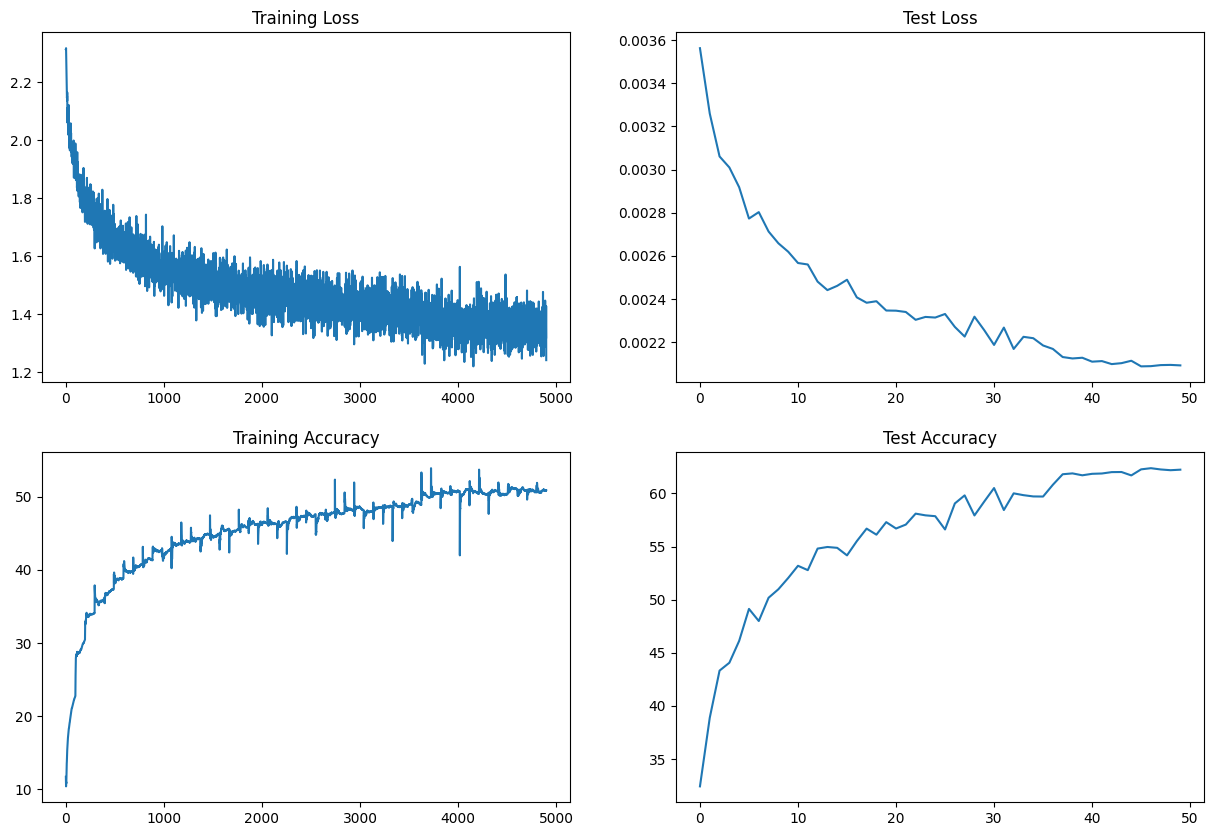

In [24]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [25]:
model911 = Net91(sequeeze_channels=[3,10,20,30,40,50,10],dp_rate=0.15)
summary(model=model911,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net91                                    [1, 10]                   --
├─Sequential: 1-1                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 20, 32, 32]           540
│    └─ReLU: 2-2                         [1, 20, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 20, 32, 32]           40
│    └─Dropout2d: 2-4                    [1, 20, 32, 32]           --
├─Sequential: 1-2                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 20, 32, 32]           3,600
│    └─ReLU: 2-6                         [1, 20, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 20, 32, 32]           40
│    └─Dropout2d: 2-8                    [1, 20, 32, 32]           --
├─Sequential: 1-3                        [1, 20, 16, 16]           --
│    └─Conv2d: 2-9                       [1, 20, 16, 16]           3,600
│    └─R

EPOCH = 1 | LR = 0.1 | Loss = 1.31 | Batch = 97 | Accuracy = 49.66: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.15it/s]


Test set: Average loss: 0.0021, Accuracy: 6115/10000 (61.15%)


EPOCH = 2 | LR = 0.1 | Loss = 1.31 | Batch = 97 | Accuracy = 49.38: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0022, Accuracy: 6015/10000 (60.15%)


EPOCH = 3 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 49.66: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0022, Accuracy: 6089/10000 (60.89%)


EPOCH = 4 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 49.56: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0021, Accuracy: 6221/10000 (62.21%)


EPOCH = 5 | LR = 0.1 | Loss = 1.39 | Batch = 97 | Accuracy = 49.78: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0022, Accuracy: 5978/10000 (59.78%)


EPOCH = 6 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 49.84: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6161/10000 (61.61%)


EPOCH = 7 | LR = 0.1 | Loss = 1.29 | Batch = 97 | Accuracy = 50.13: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6238/10000 (62.38%)


EPOCH = 8 | LR = 0.1 | Loss = 1.38 | Batch = 97 | Accuracy = 50.08: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0021, Accuracy: 6231/10000 (62.31%)


EPOCH = 9 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 49.89: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0022, Accuracy: 6092/10000 (60.92%)


EPOCH = 10 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 50.26: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6250/10000 (62.50%)


EPOCH = 11 | LR = 0.1 | Loss = 1.37 | Batch = 97 | Accuracy = 50.34: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0021, Accuracy: 6247/10000 (62.47%)


EPOCH = 12 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 50.17: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0021, Accuracy: 6277/10000 (62.77%)


EPOCH = 13 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 50.35: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6389/10000 (63.89%)


EPOCH = 14 | LR = 0.1 | Loss = 1.33 | Batch = 97 | Accuracy = 50.66: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0021, Accuracy: 6346/10000 (63.46%)


EPOCH = 15 | LR = 0.1 | Loss = 1.34 | Batch = 97 | Accuracy = 50.36: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0020, Accuracy: 6337/10000 (63.37%)


EPOCH = 16 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 50.32: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:32<00:00,  3.05it/s]


Test set: Average loss: 0.0021, Accuracy: 6283/10000 (62.83%)


EPOCH = 17 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 50.90: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0021, Accuracy: 6333/10000 (63.33%)


EPOCH = 18 | LR = 0.010000000000000002 | Loss = 1.36 | Batch = 97 | Accuracy = 51.55: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6441/10000 (64.41%)


EPOCH = 19 | LR = 0.010000000000000002 | Loss = 1.33 | Batch = 97 | Accuracy = 52.01: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6434/10000 (64.34%)


EPOCH = 20 | LR = 0.010000000000000002 | Loss = 1.35 | Batch = 97 | Accuracy = 52.06: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6432/10000 (64.32%)


EPOCH = 21 | LR = 0.010000000000000002 | Loss = 1.30 | Batch = 97 | Accuracy = 51.94: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6463/10000 (64.63%)


EPOCH = 22 | LR = 0.010000000000000002 | Loss = 1.37 | Batch = 97 | Accuracy = 51.71: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0020, Accuracy: 6482/10000 (64.82%)


EPOCH = 23 | LR = 0.010000000000000002 | Loss = 1.33 | Batch = 97 | Accuracy = 52.14: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6462/10000 (64.62%)


EPOCH = 24 | LR = 0.010000000000000002 | Loss = 1.32 | Batch = 97 | Accuracy = 52.32: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6462/10000 (64.62%)


EPOCH = 25 | LR = 0.010000000000000002 | Loss = 1.31 | Batch = 97 | Accuracy = 52.28: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6485/10000 (64.85%)


EPOCH = 26 | LR = 0.010000000000000002 | Loss = 1.40 | Batch = 97 | Accuracy = 52.34: 100%|██████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6466/10000 (64.66%)


EPOCH = 27 | LR = 0.0010000000000000002 | Loss = 1.26 | Batch = 97 | Accuracy = 52.14: 100%|█████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6466/10000 (64.66%)


EPOCH = 28 | LR = 0.0010000000000000002 | Loss = 1.25 | Batch = 97 | Accuracy = 52.24: 100%|█████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6461/10000 (64.61%)


EPOCH = 29 | LR = 0.0010000000000000002 | Loss = 1.30 | Batch = 97 | Accuracy = 52.36: 100%|█████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0020, Accuracy: 6479/10000 (64.79%)


EPOCH = 30 | LR = 0.0010000000000000002 | Loss = 1.39 | Batch = 97 | Accuracy = 52.40: 100%|█████████████████████████████████████████████| 98/98 [00:32<00:00,  3.05it/s]


Test set: Average loss: 0.0020, Accuracy: 6471/10000 (64.71%)


EPOCH = 31 | LR = 0.0010000000000000002 | Loss = 1.30 | Batch = 97 | Accuracy = 52.28: 100%|█████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0020, Accuracy: 6481/10000 (64.81%)


EPOCH = 32 | LR = 0.0010000000000000002 | Loss = 1.25 | Batch = 97 | Accuracy = 52.61: 100%|█████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0020, Accuracy: 6475/10000 (64.75%)


EPOCH = 33 | LR = 0.0010000000000000002 | Loss = 1.35 | Batch = 97 | Accuracy = 52.55: 100%|█████████████████████████████████████████████| 98/98 [00:31<00:00,  3.07it/s]


Test set: Average loss: 0.0020, Accuracy: 6477/10000 (64.77%)


EPOCH = 34 | LR = 0.0010000000000000002 | Loss = 1.30 | Batch = 97 | Accuracy = 52.27: 100%|█████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6472/10000 (64.72%)


EPOCH = 35 | LR = 0.0010000000000000002 | Loss = 1.35 | Batch = 97 | Accuracy = 52.35: 100%|█████████████████████████████████████████████| 98/98 [00:32<00:00,  3.06it/s]


Test set: Average loss: 0.0020, Accuracy: 6459/10000 (64.59%)


EPOCH = 36 | LR = 0.0010000000000000002 | Loss = 1.34 | Batch = 97 | Accuracy = 52.50: 100%|█████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6476/10000 (64.76%)


EPOCH = 37 | LR = 0.00010000000000000003 | Loss = 1.38 | Batch = 97 | Accuracy = 52.71: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6474/10000 (64.74%)


EPOCH = 38 | LR = 0.00010000000000000003 | Loss = 1.27 | Batch = 97 | Accuracy = 52.42: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.08it/s]


Test set: Average loss: 0.0020, Accuracy: 6477/10000 (64.77%)


EPOCH = 39 | LR = 0.00010000000000000003 | Loss = 1.23 | Batch = 97 | Accuracy = 52.30: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0020, Accuracy: 6462/10000 (64.62%)


EPOCH = 40 | LR = 0.00010000000000000003 | Loss = 1.25 | Batch = 97 | Accuracy = 52.64: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6467/10000 (64.67%)


EPOCH = 41 | LR = 1.0000000000000004e-05 | Loss = 1.34 | Batch = 97 | Accuracy = 52.40: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6477/10000 (64.77%)


EPOCH = 42 | LR = 1.0000000000000004e-05 | Loss = 1.33 | Batch = 97 | Accuracy = 52.62: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6466/10000 (64.66%)


EPOCH = 43 | LR = 1.0000000000000004e-05 | Loss = 1.37 | Batch = 97 | Accuracy = 52.36: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6479/10000 (64.79%)


EPOCH = 44 | LR = 1.0000000000000004e-05 | Loss = 1.38 | Batch = 97 | Accuracy = 52.46: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6478/10000 (64.78%)


EPOCH = 45 | LR = 1.0000000000000004e-06 | Loss = 1.33 | Batch = 97 | Accuracy = 52.20: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.12it/s]


Test set: Average loss: 0.0020, Accuracy: 6476/10000 (64.76%)


EPOCH = 46 | LR = 1.0000000000000004e-06 | Loss = 1.36 | Batch = 97 | Accuracy = 52.42: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0020, Accuracy: 6460/10000 (64.60%)


EPOCH = 47 | LR = 1.0000000000000004e-06 | Loss = 1.30 | Batch = 97 | Accuracy = 52.35: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.10it/s]


Test set: Average loss: 0.0020, Accuracy: 6471/10000 (64.71%)


EPOCH = 48 | LR = 1.0000000000000004e-06 | Loss = 1.31 | Batch = 97 | Accuracy = 52.46: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.09it/s]


Test set: Average loss: 0.0020, Accuracy: 6483/10000 (64.83%)


EPOCH = 49 | LR = 1.0000000000000005e-07 | Loss = 1.31 | Batch = 97 | Accuracy = 52.53: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6464/10000 (64.64%)


EPOCH = 50 | LR = 1.0000000000000005e-07 | Loss = 1.30 | Batch = 97 | Accuracy = 51.91: 100%|████████████████████████████████████████████| 98/98 [00:31<00:00,  3.11it/s]


Test set: Average loss: 0.0020, Accuracy: 6472/10000 (64.72%)


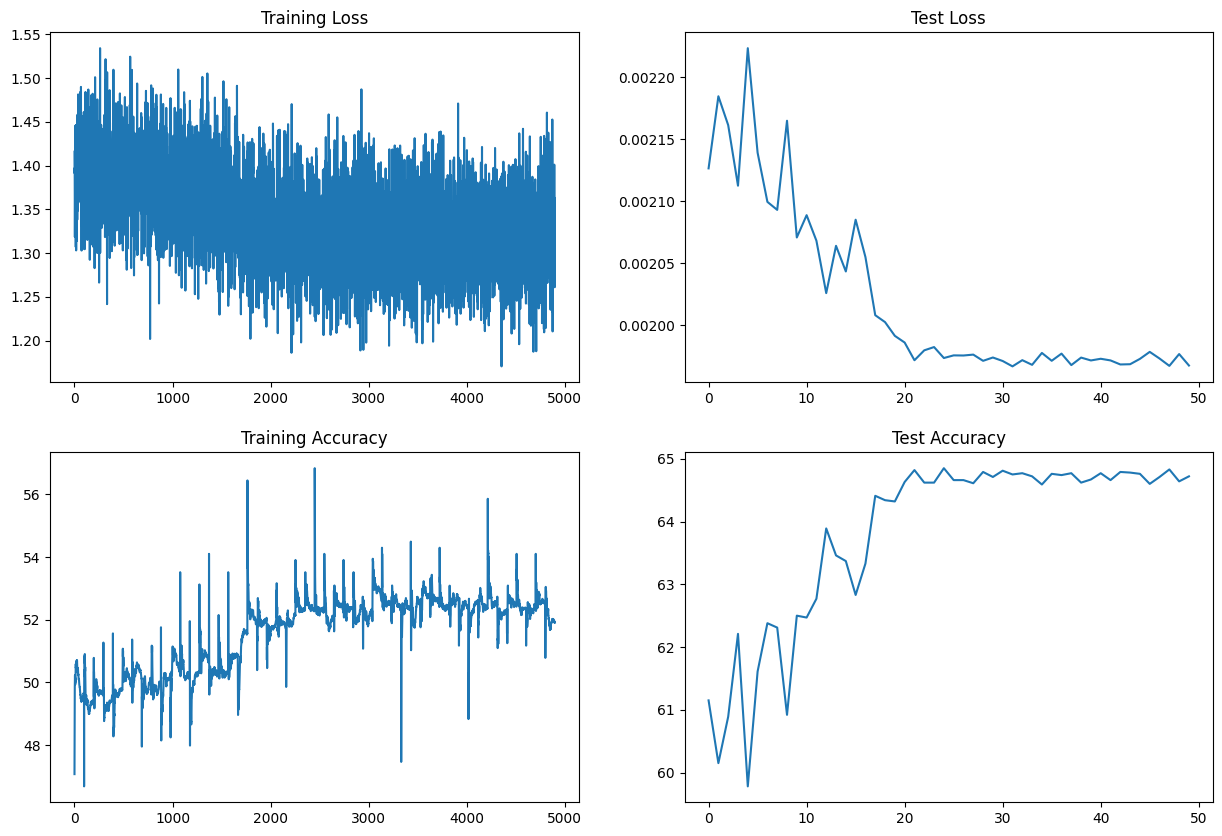

In [28]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model91.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model91, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model91, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model91.state_dict(),f='./bmodels/model91.pth')
    scheduler.step(test_loss)

plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

In [37]:
class Net91Extended(nn.Module):
        def __init__(self,sequeeze_channels:list,dp_rate=0.1):
            super(Net91Extended,self).__init__()
            self.dp_rate=dp_rate

            self.C11 =  nn.Sequential(
                        # nn.Conv2d(in_channels=sequeeaze_channels[0] ,out_channels=sequeeze_channels[0],groups=sequeeze_channels[0], kernel_size=3,bias=False,padding=1,stride=1),
                        # nn.Conv2d(in_channels=sequeeze_channels[0], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        nn.Conv2d(
                            in_channels=sequeeze_channels[0],
                            out_channels=sequeeze_channels[2],
                            kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate),

                        nn.Conv2d(
                            in_channels=sequeeze_channels[2],
                            out_channels=sequeeze_channels[2],
                            kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)

                    )

            self.C12 = nn.Sequential(
                        # nn.Conv2d(in_channels=sequeeze_channels[2] ,out_channels=sequeeze_channels[2],groups=sequeeze_channels[2], kernel_size=3,bias=False,padding=1,stride=1),
                        # nn.Conv2d(in_channels=sequeeze_channels[2], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        
                        nn.Conv2d(
                            in_channels=sequeeze_channels[2],
                            out_channels=sequeeze_channels[2],
                            kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate),

                        nn.Conv2d(
                            in_channels=sequeeze_channels[2],
                            out_channels=sequeeze_channels[2],
                            kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.C13 = nn.Sequential(
                        # nn.Conv2d(in_channels=sequeeze_channels[2] ,out_channels=sequeeze_channels[2],groups=sequeeze_channels[2], kernel_size=3,bias=False,padding=1,stride=1),
                        # nn.Conv2d(in_channels=sequeeze_channels[2], out_channels=sequeeze_channels[2], kernel_size=1,padding=0,bias=False),
                        nn.Conv2d(in_channels=sequeeze_channels[2],
                                  out_channels=sequeeze_channels[2],
                                  kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate),

                        nn.Conv2d(in_channels=sequeeze_channels[2],
                                  out_channels=sequeeze_channels[2],
                                  kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[2]),
                        nn.Dropout2d(self.dp_rate)
                    )
            self.T11 = nn.Sequential(
                nn.Conv2d(in_channels=sequeeze_channels[2],out_channels=sequeeze_channels[1],kernel_size=1,stride=1,bias=False)
            )


            self.C21  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[1],groups=sequeeze_channels[1],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate),


                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[1],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[1],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C22 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate),

                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C23 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate),

                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],groups=sequeeze_channels[4],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[4],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[4]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T21 = nn.Sequential(nn.Conv2d(in_channels=sequeeze_channels[4],out_channels=sequeeze_channels[3],kernel_size=1,stride=1,bias=False))

            
            self.C31  = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[3],groups=sequeeze_channels[3],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate),

                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[3],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C32  =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate),

                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=1,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.C33 =  nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate),

                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],groups=sequeeze_channels[5],kernel_size=3,bias=False,padding=1,stride=1),
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=1,padding=0,bias=False),
                        # nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[5],kernel_size=3,stride=2,padding=1,bias=False),
                        nn.ReLU(inplace=True),
                        nn.BatchNorm2d(sequeeze_channels[5]),
                        nn.Dropout2d(self.dp_rate)
            )
            self.T31 = nn.Sequential(
                        nn.Conv2d(in_channels=sequeeze_channels[5],out_channels=sequeeze_channels[6],kernel_size=1,stride=1,bias=False)
            )           
            self.gap = nn.AdaptiveAvgPool2d(output_size=1)
            
        def forward(self,x):
            x = self.C11(x)
            x = x+self.C12(x)            
            x = self.C13(x)
            x = self.T11(x)
            
            x = self.C21(x)
            x = x+self.C22(x)
            x = self.C23(x)
            x = self.T21(x)

            x = self.C31(x)
            x = x+self.C32(x)
            x = self.C33(x)
            x = self.T31(x)

            x = self.gap(x)
            return F.log_softmax(x.view(-1,10), dim=1)


model91Extended = Net91Extended(sequeeze_channels=[3,10,20,30,40,50,10],dp_rate=0.15)
summary(model=model91Extended,input_size=(1,3,32,32),device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net91Extended                            [1, 10]                   --
├─Sequential: 1-1                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 20, 32, 32]           540
│    └─ReLU: 2-2                         [1, 20, 32, 32]           --
│    └─BatchNorm2d: 2-3                  [1, 20, 32, 32]           40
│    └─Dropout2d: 2-4                    [1, 20, 32, 32]           --
│    └─Conv2d: 2-5                       [1, 20, 32, 32]           3,600
│    └─ReLU: 2-6                         [1, 20, 32, 32]           --
│    └─BatchNorm2d: 2-7                  [1, 20, 32, 32]           40
│    └─Dropout2d: 2-8                    [1, 20, 32, 32]           --
├─Sequential: 1-2                        [1, 20, 32, 32]           --
│    └─Conv2d: 2-9                       [1, 20, 32, 32]           3,600
│    └─ReLU: 2-10                        [1, 20, 32, 32]           --
│    └─B

EPOCH = 1 | LR = 0.1 | Loss = 1.94 | Batch = 97 | Accuracy = 19.55: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:03<00:00,  1.55it/s]


Test set: Average loss: 0.0037, Accuracy: 2690/10000 (26.90%)


EPOCH = 2 | LR = 0.1 | Loss = 1.94 | Batch = 97 | Accuracy = 26.15: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:09<00:00,  1.41it/s]


Test set: Average loss: 0.0037, Accuracy: 2945/10000 (29.45%)


EPOCH = 3 | LR = 0.1 | Loss = 1.88 | Batch = 97 | Accuracy = 29.06: 100%|████████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.0033, Accuracy: 3721/10000 (37.21%)


EPOCH = 4 | LR = 0.1 | Loss = 1.79 | Batch = 97 | Accuracy = 31.57: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:11<00:00,  1.38it/s]


Test set: Average loss: 0.0032, Accuracy: 3972/10000 (39.72%)


EPOCH = 5 | LR = 0.1 | Loss = 1.73 | Batch = 97 | Accuracy = 33.89: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:01<00:00,  1.61it/s]


Test set: Average loss: 0.0031, Accuracy: 4090/10000 (40.90%)


EPOCH = 6 | LR = 0.1 | Loss = 1.67 | Batch = 97 | Accuracy = 35.28: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:11<00:00,  1.37it/s]


Test set: Average loss: 0.0030, Accuracy: 4383/10000 (43.83%)


EPOCH = 7 | LR = 0.1 | Loss = 1.67 | Batch = 97 | Accuracy = 36.73: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:06<00:00,  1.48it/s]


Test set: Average loss: 0.0029, Accuracy: 4503/10000 (45.03%)


EPOCH = 8 | LR = 0.1 | Loss = 1.66 | Batch = 97 | Accuracy = 37.89: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:08<00:00,  1.43it/s]


Test set: Average loss: 0.0029, Accuracy: 4629/10000 (46.29%)


EPOCH = 9 | LR = 0.1 | Loss = 1.57 | Batch = 97 | Accuracy = 39.18: 100%|████████████████████████████████████████████████████████████████| 98/98 [01:10<00:00,  1.39it/s]


Test set: Average loss: 0.0028, Accuracy: 4854/10000 (48.54%)


EPOCH = 10 | LR = 0.1 | Loss = 1.56 | Batch = 97 | Accuracy = 39.95: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:08<00:00,  1.44it/s]


Test set: Average loss: 0.0028, Accuracy: 4919/10000 (49.19%)


EPOCH = 11 | LR = 0.1 | Loss = 1.57 | Batch = 97 | Accuracy = 40.62: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:13<00:00,  1.33it/s]


Test set: Average loss: 0.0027, Accuracy: 5019/10000 (50.19%)


EPOCH = 12 | LR = 0.1 | Loss = 1.54 | Batch = 97 | Accuracy = 41.52: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:20<00:00,  1.21it/s]


Test set: Average loss: 0.0026, Accuracy: 5118/10000 (51.18%)


EPOCH = 13 | LR = 0.1 | Loss = 1.63 | Batch = 97 | Accuracy = 42.37: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:59<00:00,  1.64it/s]


Test set: Average loss: 0.0026, Accuracy: 5162/10000 (51.62%)


EPOCH = 14 | LR = 0.1 | Loss = 1.53 | Batch = 97 | Accuracy = 42.54: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:20<00:00,  1.22it/s]


Test set: Average loss: 0.0026, Accuracy: 5271/10000 (52.71%)


EPOCH = 15 | LR = 0.1 | Loss = 1.50 | Batch = 97 | Accuracy = 43.16: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:52<00:00,  1.86it/s]


Test set: Average loss: 0.0025, Accuracy: 5422/10000 (54.22%)


EPOCH = 16 | LR = 0.1 | Loss = 1.52 | Batch = 97 | Accuracy = 43.37: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:19<00:00,  1.23it/s]


Test set: Average loss: 0.0025, Accuracy: 5406/10000 (54.06%)


EPOCH = 17 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 44.14: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:50<00:00,  1.93it/s]


Test set: Average loss: 0.0025, Accuracy: 5483/10000 (54.83%)


EPOCH = 18 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 44.31: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:20<00:00,  1.22it/s]


Test set: Average loss: 0.0025, Accuracy: 5371/10000 (53.71%)


EPOCH = 19 | LR = 0.1 | Loss = 1.50 | Batch = 97 | Accuracy = 44.83: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:48<00:00,  2.00it/s]


Test set: Average loss: 0.0024, Accuracy: 5607/10000 (56.07%)


EPOCH = 20 | LR = 0.1 | Loss = 1.49 | Batch = 97 | Accuracy = 45.12: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:21<00:00,  1.21it/s]


Test set: Average loss: 0.0024, Accuracy: 5717/10000 (57.17%)


EPOCH = 21 | LR = 0.1 | Loss = 1.50 | Batch = 97 | Accuracy = 45.41: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.08it/s]


Test set: Average loss: 0.0024, Accuracy: 5592/10000 (55.92%)


EPOCH = 22 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 45.90: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:21<00:00,  1.20it/s]


Test set: Average loss: 0.0023, Accuracy: 5758/10000 (57.58%)


EPOCH = 23 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 45.85: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.05it/s]


Test set: Average loss: 0.0024, Accuracy: 5708/10000 (57.08%)


EPOCH = 24 | LR = 0.1 | Loss = 1.59 | Batch = 97 | Accuracy = 46.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:22<00:00,  1.20it/s]


Test set: Average loss: 0.0024, Accuracy: 5731/10000 (57.31%)


EPOCH = 25 | LR = 0.1 | Loss = 1.46 | Batch = 97 | Accuracy = 46.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:47<00:00,  2.06it/s]


Test set: Average loss: 0.0023, Accuracy: 5737/10000 (57.37%)


EPOCH = 26 | LR = 0.1 | Loss = 1.47 | Batch = 97 | Accuracy = 46.86: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:21<00:00,  1.20it/s]


Test set: Average loss: 0.0023, Accuracy: 5870/10000 (58.70%)


EPOCH = 27 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 47.44: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:45<00:00,  2.14it/s]


Test set: Average loss: 0.0023, Accuracy: 5855/10000 (58.55%)


EPOCH = 28 | LR = 0.1 | Loss = 1.51 | Batch = 97 | Accuracy = 47.82: 100%|███████████████████████████████████████████████████████████████| 98/98 [01:19<00:00,  1.23it/s]


Test set: Average loss: 0.0022, Accuracy: 5947/10000 (59.47%)


EPOCH = 29 | LR = 0.1 | Loss = 1.40 | Batch = 97 | Accuracy = 47.60: 100%|███████████████████████████████████████████████████████████████| 98/98 [00:46<00:00,  2.11it/s]


Test set: Average loss: 0.0022, Accuracy: 5998/10000 (59.98%)


EPOCH = 30 | LR = 0.1 | Loss = 1.35 | Batch = 97 | Accuracy = 47.89: 100%|█████████████████████████████████████████████████████████████| 98/98 [1:01:39<00:00, 37.75s/it]


Test set: Average loss: 0.0022, Accuracy: 5947/10000 (59.47%)


EPOCH = 31 | LR = 0.1 | Loss = 1.45 | Batch = 97 | Accuracy = 48.22: 100%|███████████████████████████████████████████████████████████████| 98/98 [10:23<00:00,  6.37s/it]


Test set: Average loss: 0.0022, Accuracy: 6077/10000 (60.77%)


EPOCH = 32 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 48.71: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:21<00:00,  1.44s/it]


Test set: Average loss: 0.0022, Accuracy: 6029/10000 (60.29%)


EPOCH = 33 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 48.61: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:20<00:00,  1.43s/it]


Test set: Average loss: 0.0022, Accuracy: 5983/10000 (59.83%)


EPOCH = 34 | LR = 0.1 | Loss = 1.42 | Batch = 97 | Accuracy = 49.00: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:21<00:00,  1.44s/it]


Test set: Average loss: 0.0021, Accuracy: 6175/10000 (61.75%)


EPOCH = 35 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 48.92: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:12<00:00,  1.35s/it]


Test set: Average loss: 0.0021, Accuracy: 6120/10000 (61.20%)


EPOCH = 36 | LR = 0.1 | Loss = 1.39 | Batch = 97 | Accuracy = 49.28: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:21<00:00,  1.44s/it]


Test set: Average loss: 0.0021, Accuracy: 6232/10000 (62.32%)


EPOCH = 37 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 49.40: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:25<00:00,  1.48s/it]


Test set: Average loss: 0.0021, Accuracy: 6205/10000 (62.05%)


EPOCH = 38 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 49.54: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:08<00:00,  1.31s/it]


Test set: Average loss: 0.0021, Accuracy: 6127/10000 (61.27%)


EPOCH = 39 | LR = 0.1 | Loss = 1.41 | Batch = 97 | Accuracy = 49.93: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:22<00:00,  1.45s/it]


Test set: Average loss: 0.0021, Accuracy: 6228/10000 (62.28%)


EPOCH = 40 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 49.63: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:19<00:00,  1.43s/it]


Test set: Average loss: 0.0021, Accuracy: 6295/10000 (62.95%)


EPOCH = 41 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 49.87: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:22<00:00,  1.45s/it]


Test set: Average loss: 0.0021, Accuracy: 6207/10000 (62.07%)


EPOCH = 42 | LR = 0.1 | Loss = 1.48 | Batch = 97 | Accuracy = 50.06: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:20<00:00,  1.44s/it]


Test set: Average loss: 0.0021, Accuracy: 6354/10000 (63.54%)


EPOCH = 43 | LR = 0.1 | Loss = 1.32 | Batch = 97 | Accuracy = 50.25: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:20<00:00,  1.43s/it]


Test set: Average loss: 0.0021, Accuracy: 6177/10000 (61.77%)


EPOCH = 44 | LR = 0.1 | Loss = 1.31 | Batch = 97 | Accuracy = 50.57: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:21<00:00,  1.45s/it]


Test set: Average loss: 0.0020, Accuracy: 6382/10000 (63.82%)


EPOCH = 45 | LR = 0.1 | Loss = 1.36 | Batch = 97 | Accuracy = 50.73: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:06<00:00,  1.29s/it]


Test set: Average loss: 0.0021, Accuracy: 6238/10000 (62.38%)


EPOCH = 46 | LR = 0.1 | Loss = 1.30 | Batch = 97 | Accuracy = 50.69: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:20<00:00,  1.43s/it]


Test set: Average loss: 0.0021, Accuracy: 6318/10000 (63.18%)


EPOCH = 47 | LR = 0.1 | Loss = 1.27 | Batch = 97 | Accuracy = 51.16: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:24<00:00,  1.47s/it]


Test set: Average loss: 0.0020, Accuracy: 6394/10000 (63.94%)


EPOCH = 48 | LR = 0.1 | Loss = 1.44 | Batch = 97 | Accuracy = 51.30: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:16<00:00,  1.39s/it]


Test set: Average loss: 0.0020, Accuracy: 6397/10000 (63.97%)


EPOCH = 49 | LR = 0.1 | Loss = 1.26 | Batch = 97 | Accuracy = 51.20: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:20<00:00,  1.43s/it]


Test set: Average loss: 0.0021, Accuracy: 6299/10000 (62.99%)


EPOCH = 50 | LR = 0.1 | Loss = 1.25 | Batch = 97 | Accuracy = 51.69: 100%|███████████████████████████████████████████████████████████████| 98/98 [02:21<00:00,  1.44s/it]


Test set: Average loss: 0.0020, Accuracy: 6437/10000 (64.37%)


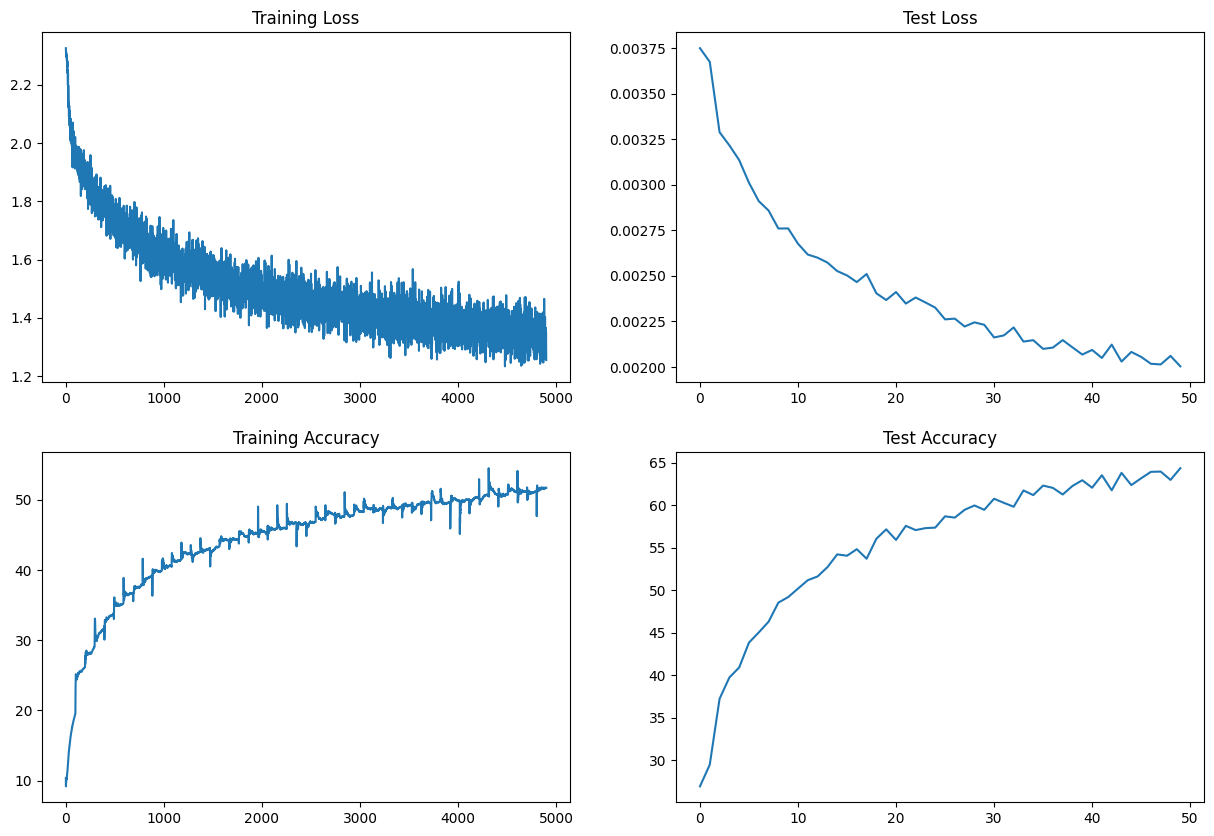

In [38]:
prev_test_loss = float('inf')

optimizer = optim.SGD(params=model91Extended.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=3)
criterion = nn.NLLLoss()
trainer = Trainer(model=model91Extended, train_loader=atrain_loader, optimizer=optimizer, criterion=criterion, device=device)
tester = Tester(model=model91Extended, test_loader=atest_loader,criterion=criterion, device=device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(obj=model91Extended.state_dict(),f='./bmodels/model91Extended.pth')
    scheduler.step(test_loss)

plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)